# 설문조사 데이터 분류 코드 (분석 전 예상)

- 데이터셋의 크기가 크지 않기 때문에 큰 데이터셋에 쓰이는 복잡한 모델인 신경망보다, 머신러닝의 의사결정나무 혹은 앙상블 모델이 적절할 것으로 예상

- 또한 데이터셋이 크지 않기 때문에 정확도를 높이기 위해 oversampling의 방법, 데이터 증식이 필요할 것으로 보임

- 랜덤 포레스트와 부스팅 계열은 변수별 중요도를 추출할 수 있기 때문에 모델 구현과 별개로 차후 실제 데이터셋의 분석과 결론에 이용할 예정

## 모듈 불러오기

In [ ]:
pip install catboost

In [ ]:
pip install lightgbm

In [ ]:
!pip install pydotplus

In [ ]:
!pip install graphviz

In [ ]:
pip install Boruta

     |████████████████████████████████| 56 kB 3.2 MB/s 


In [ ]:
# 드라이브 로드 패키지
from google.colab import drive
drive.mount('/content/drive')

# 데이터 전처리 패키지
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 기계학습 모델 구축 및 평가 패키지
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import BaggingClassifier
from boruta import BorutaPy

# 데이터 시각화 패키지
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.tree import plot_tree # 의사결정 나무 규칙을 시각화하기 위한 패키지 
from sklearn.tree import export_graphviz
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib
import pydotplus
import plotly.express as px
from IPython.core.display import Image
matplotlib.rcParams['axes.unicode_minus'] = False

%matplotlib inline
# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

# 기타
from tqdm import tqdm
import pickle
import warnings

Mounted at /content/drive


## 데이터 전처리

In [ ]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# 일반부원 데이터
data1 = pd.read_csv('/gdrive/Shared drives/datathon_2021/practice.csv',encoding = 'cp949')  

# 집행부원 데이터
data2 = pd.read_csv('/gdrive/Shared drives/datathon_2021/practice2.csv') 

# 최종 설문 데이터
data3 = pd.read_csv('/gdrive/Shared drives/datathon_2021/practice3.csv') 


In [ ]:
# 사용 안하는 column 제거

data1.drop(['타임스탬프', '기프티콘 추첨을 위한 전화번호를 남겨 주세요. (ex 01012345678)'], axis = 1, inplace = True)
data2.drop(['타임스탬프', '기프티콘 추첨을 위한 전화번호를 남겨 주세요. (ex 01012345678)'], axis = 1, inplace = True)
data3.drop(['타임스탬프', '기프티콘 추첨을 위한 전화번호를 남겨 주세요. (ex 01012345678)'], axis = 1, inplace = True)

In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 30 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   속해있는 동아리명을 적어주세요.                                        42 non-null     object
 1   동아리 가입 년도 및 학기를 적어주세요. ex) 2020-1                        42 non-null     object
 2   동아리에서 활동한 기간을 적어주세요. (단위: 학기) ex 활동학기가 2학기인 경우 2         42 non-null     object
 3   동아리 활동에 얼마나 적극적으로 참여하셨나요?                                42 non-null     object
 4   동아리 분위기가 학업에 영향을 많이 주는 편인가요?                             42 non-null     object
 5   매주 회의, 연습 등 동아리 활동에 소요되는 시간이 어느 정도 인가요?                  42 non-null     object
 6   같은 학과 학생보다 동아리원들과 더 친밀하다고 생각하시나요?                        42 non-null     object
 7   동아리방 시설은 어느 정도인가요?                                       42 non-null     object
 8   술을 많이 마시는 분위기 인가요?                        

In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 37 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   속해있는 동아리명을 적어주세요.                                        7 non-null      object
 1   동아리 가입 년도 및 학기를 적어주세요. ex) 2020-1                        7 non-null      object
 2   동아리에서 활동한 기간을 적어주세요. (단위: 학기) ex 활동학기가 2학기인 경우 2         7 non-null      object
 3   동아리 내부에서 맡고있는 역할을 적어주세요                                  7 non-null      object
 4   동아리는 주로 몇학년으로 구성되어 있나요?                                  7 non-null      object
 5   동아리의 성비는 어느 정도인가요?                                       7 non-null      object
 6   학기당 공식적인 동아리 회비는 어느 정도인가요?                               7 non-null      object
 7   동아리원 대부분의 활동 기간은 어느 정도인가요?                               7 non-null      object
 8   동아리 구성원은 다양한 학과 학생으로 이루어져 있나요?              

In [ ]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 46 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   속해있는 동아리의 분과를 골라주세요.                                     112 non-null    object
 1   동아리 가입 년도 및 학기를 적어주세요. ex) 2020-1                        112 non-null    object
 2   동아리에서 활동한 기간을 적어주세요. (단위: 학기) ex 활동학기가 2학기인 경우 2         112 non-null    object
 3   동아리 내부에서 맡고있는, 혹은 맡았던 역할을 적어주세요                          112 non-null    object
 4   동아리는 주로 몇학년으로 구성되어 있나요?                                  112 non-null    object
 5   동아리의 성비는 어느 정도인가요?                                       112 non-null    object
 6   학기당 공식적인 동아리 회비는 어느 정도인가요?                               112 non-null    object
 7   동아리원 대부분의 활동 기간은 어느 정도인가요?                               112 non-null    object
 8   동아리 구성원은 다양한 학과 학생으로 이루어져 있나요?          

In [ ]:
# 동아리명 column 생성 후 동아리명 채워넣기

data3.insert(0, '동아리명', 0)

# 각 분과별로 선택한 동아리명 넣기

for i in range(len(data3)):
  if data3['속해있는 동아리의 분과를 골라주세요.'][i] == '기악예술분과':
    data3['동아리명'][i] =  data3['[기악예술분과] 속해있는 동아리를 골라주세요'][i]
  elif data3['속해있는 동아리의 분과를 골라주세요.'][i] == '종교분과':
    data3['동아리명'][i] =  data3['[종교분과] 속해있는 동아리를 골라주세요'][i]
  elif data3['속해있는 동아리의 분과를 골라주세요.'][i] == '사회분과':
    data3['동아리명'][i] =  data3['[사회분과] 속해있는 동아리를 골라주세요'][i]  
  elif data3['속해있는 동아리의 분과를 골라주세요.'][i] == '언어분과':
    data3['동아리명'][i] =  data3['[언어분과] 속해있는 동아리를 골라주세요.'][i]
  elif data3['속해있는 동아리의 분과를 골라주세요.'][i] == '전시창작분과':
    data3['동아리명'][i] =  data3['[전시창작분과] 속해있는 동아리를 골라주세요.'][i] 
  elif data3['속해있는 동아리의 분과를 골라주세요.'][i] == '인문과학분과':
    data3['동아리명'][i] =  data3['[인문과학분과] 속해있는 동아리를 골라주세요'][i] 
  elif data3['속해있는 동아리의 분과를 골라주세요.'][i] == '생활문화분과':
    data3['동아리명'][i] =  data3['[생활문화분과] 속해있는 동아리를 골라주세요'][i] 
  elif data3['속해있는 동아리의 분과를 골라주세요.'][i] == '체육분과':
    data3['동아리명'][i] =  data3['[체육분과] 속해있는 동아리를 골라주세요'][i] 
  elif data3['속해있는 동아리의 분과를 골라주세요.'][i] == '연행예술분과':
    data3['동아리명'][i] =  data3['[연행예술분과] 속해있는 동아리를 골라주세요.'][i] 


# 동아리명을 알아냈으니 해당 column들 삭제

data3.drop(['속해있는 동아리의 분과를 골라주세요.', 
            '[기악예술분과] 속해있는 동아리를 골라주세요',
            '[종교분과] 속해있는 동아리를 골라주세요',
            '[사회분과] 속해있는 동아리를 골라주세요',
            '[언어분과] 속해있는 동아리를 골라주세요.',
            '[전시창작분과] 속해있는 동아리를 골라주세요.',
            '[인문과학분과] 속해있는 동아리를 골라주세요',
            '[생활문화분과] 속해있는 동아리를 골라주세요',
            '[체육분과] 속해있는 동아리를 골라주세요',
            '[연행예술분과] 속해있는 동아리를 골라주세요.'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# 설문조사 문항이 너무 길었기 때문에 컬럼명을 직관적으로 축약

data1.columns = ["동아리명",	"가입시기", "활동기간",	"적극성 정도",	"학업에의 영향",	"동아리활동 소요시간",	"친밀도",	"동아리방 시설",	"술문화",	"기대했던 활동 유무"	,"추천하는 학년",	"신입부원과 친해지는 정도",	"동아리 평균 활동비",	"친목행사",	"자유로운 동아리방 사용",	"수평적인 분위기",	"소속감",	"활동 강제 정도",	"코로나19 대비 방안마련",	"활동적인 부원들"	,"동아리원 실력",	"학교외 활동",	"초심자를 위한 활동",	"동아리 장비가 갖춰진 정도"	,"소모임, 스터디","원하는 활동 진행"	,"외부 지원",	"활동 빈도",	"활동 장소"	,"공통 주제"]
data2.columns = ["동아리명",	"가입시기", "활동기간",	 "역할", "주된 학년구성", "성비", "회비", "대부분의 활동기간",  "다양한 학과구성", "선발절차", "행사 규모",	"학업에의 영향",	"동아리활동 소요시간",	"친밀도",	"동아리방 시설",	"술문화",	"기대했던 활동 유무"	,"추천하는 학년",	"신입부원과 친해지는 정도",	"동아리 평균 활동비",	"친목행사",	"자유로운 동아리방 사용",	"수평적인 분위기",	"소속감",	"활동 강제 정도",	"코로나19 대비 방안마련",	"활동적인 부원들"	,"동아리원 실력",	"학교외 활동",	"초심자를 위한 활동",	"동아리 장비가 갖춰진 정도"	,"소모임, 스터디","원하는 활동 진행"	,"외부 지원",	"활동 빈도",	"활동 장소"	,"공통 주제"]
data3.columns = ["동아리명",	"가입시기", "활동기간",	 "역할", "주된 학년구성", "성비", "회비", "대부분의 활동기간",  "다양한 학과구성", "선발절차", "행사 규모",	"학업에의 영향",	"동아리활동 소요시간",	"친밀도",	"동아리방 시설",	"술문화",	"기대했던 활동 유무"	,"추천하는 학년",	"신입부원과 친해지는 정도",	"동아리 평균 활동비",	"친목행사",	"자유로운 동아리방 사용",	"수평적인 분위기",	"소속감",	"활동 강제 정도",	"코로나19 대비 방안마련",	"활동적인 부원들"	,"동아리원 실력",	"학교외 활동",	"초심자를 위한 활동",	"동아리 장비가 갖춰진 정도"	,"소모임, 스터디","원하는 활동 진행"	,"외부 지원",	"활동 빈도",	"활동 장소"	,"공통 주제"]

In [ ]:
# 동아리명 표준화 시키기 : data1

for i in range(len(data1)):
  
  data1['동아리명'][i] = str(data1['동아리명'][i])

  if '고려대학교 ' in data1['동아리명'][i]:
    data1['동아리명'][i] = data1['동아리명'][i][6:]

  elif '고려대학교' in data1['동아리명'][i]:
    data1['동아리명'][i] = data1['동아리명'][i][5:]

  elif '한국기독학생회' in data1['동아리명'][i]:
    data1['동아리명'][i] = 'IVF'

  elif data1["동아리명"][i] == 'ivf':
    data1['동아리명'][i] = 'IVF'

  elif data1["동아리명"][i] == 'KUbC':
    data1['동아리명'][i] = 'KUBC'

  elif data1['동아리명'][i] == '관현악부':
    data1['동아리명'][i] = '관현악단'

  elif data1['동아리명'][i] == '스쿼시동아리':
    data1['동아리명'][i] = "ENTHES"

  data1['동아리명'][i] = data1['동아리명'][i].replace(" ","")


In [ ]:
# 동아리명 표준화 시키기 : data2

for i in range(len(data2)):
  
  data2['동아리명'][i] = str(data2['동아리명'][i])

  if '고려대학교 ' in data2['동아리명'][i]:
    data2['동아리명'][i] = data2['동아리명'][i][6:]

  elif '고려대학교' in data2['동아리명'][i]:
    data2['동아리명'][i] = data2['동아리명'][i][5:]

  elif '한국기독학생회' in data2['동아리명'][i]:
    data2['동아리명'][i] = 'IVF'

  elif data2["동아리명"][i] == 'ivf':
    data2['동아리명'][i] = 'IVF'

  elif data2["동아리명"][i] == 'KUbC':
    data2['동아리명'][i] = 'KUBC'

  elif data2['동아리명'][i] == '관현악부':
    data2['동아리명'][i] = '관현악단'

  data2['동아리명'][i] = data2['동아리명'][i].replace(" ","")


In [ ]:
# 동아리명 표준화 시키기 : data3

for i in range(len(data3)):
  
  data3['동아리명'][i] = str(data3['동아리명'][i])

  if '고려대학교 ' in data3['동아리명'][i]:
    data3['동아리명'][i] = data3['동아리명'][i][6:]

  elif '고려대학교' in data3['동아리명'][i]:
    data3['동아리명'][i] = data3['동아리명'][i][5:]

  elif '한국기독학생회' in data3['동아리명'][i]:
    data3['동아리명'][i] = 'IVF'

  elif data3["동아리명"][i] == 'ivf':
    data3['동아리명'][i] = 'IVF'

  elif data3["동아리명"][i] == 'KUbC':
    data3['동아리명'][i] = 'KUBC'

  elif data3['동아리명'][i] == '관현악부':
    data3['동아리명'][i] = '관현악단'

  elif data3['동아리명'][i] == '젋은예수':
    data3['동아리명'][i] = '젊은예수'

  elif data3['동아리명'][i] == '호전회':
    data3['동아리명'][i] = '호진회' 

  data3['동아리명'][i] = data3['동아리명'][i].replace(" ","")


In [ ]:
data2_3 = pd.concat([data2, data3], ignore_index=True)

In [ ]:
data2_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   동아리명            119 non-null    object
 1   가입시기            119 non-null    object
 2   활동기간            119 non-null    object
 3   역할              119 non-null    object
 4   주된 학년구성         119 non-null    object
 5   성비              119 non-null    object
 6   회비              119 non-null    object
 7   대부분의 활동기간       119 non-null    object
 8   다양한 학과구성        119 non-null    object
 9   선발절차            119 non-null    object
 10  행사 규모           119 non-null    object
 11  학업에의 영향         119 non-null    object
 12  동아리활동 소요시간      119 non-null    object
 13  친밀도             119 non-null    object
 14  동아리방 시설         119 non-null    object
 15  술문화             119 non-null    object
 16  기대했던 활동 유무      119 non-null    object
 17  추천하는 학년         119 non-null    object
 18  신입부원과 친해지는

##### [주된 학년구성] column

In [ ]:
data2_3.groupby('동아리명')["주된 학년구성"].agg(**{'학년구성':lambda x:x.mode()}).reset_index()

,동아리명,학년구성
0,ALC,고루 구성되어 있음
1,ATP,고루 구성되어 있음
2,CCC,고루 구성되어 있음
3,ECS,"3, 4"
4,ENM,고루 구성되어 있음
5,KUBC,고루 구성되어 있음
6,KUCC,고루 구성되어 있음
7,KUDT,고루 구성되어 있음
8,KULAX,4
9,KURC,"[1, 2, 고루 구성되어 있음]"


대부분 동아리의 경우 학년이 고루 구성되어 있는 것이 최빈값이다. 아닌 경우 동아리 설문 응답자의 수가 1~2명이었기 때문에 정확한 정보가 아니라고 생각. 따라서 이 column은 고려하지 않을 예정이다.

##### [성비] column

In [ ]:
data2_3_성비 = data2_3.groupby('동아리명')["성비"].agg(**{'성비':lambda x:x.mode()}).reset_index()

In [ ]:
data2_3_성비

,동아리명,성비
0,ALC,비슷함
1,ATP,비슷함
2,CCC,비슷함
3,ECS,남자 비율이 높음
4,ENM,비슷함
5,KUBC,남자 비율이 높음
6,KUCC,비슷함
7,KUDT,여자 비율이 높음
8,KULAX,여자 비율이 높음
9,KURC,"[비슷함, 여자 비율이 높음]"


In [ ]:
for i in range(len(data2_3_성비)):
  data2_3_성비['성비'][i] = str(data2_3_성비['성비'][i])
  if '[' in data2_3_성비['성비'][i]:
    data2_3_성비['성비'][i] = '비슷함'

##### [회비] column

In [ ]:
data2_3_회비 = data2_3.groupby('동아리명')["회비"].agg(**{'회비':lambda x:x.mode()}).reset_index()

In [ ]:
data2_3_회비

,동아리명,회비
0,ALC,1만원 초과 3만원 이하
1,ATP,3만원 초과
2,CCC,1만원 이하
3,ECS,1만원 초과 3만원 이하
4,ENM,1만원 이하
5,KUBC,3만원 초과
6,KUCC,1만원 초과 3만원 이하
7,KUDT,3만원 초과
8,KULAX,1만원 이하
9,KURC,"[1만원 이하, 1만원 초과 3만원 이하]"


In [ ]:
for i in range(len(data2_3_회비)):
  data2_3_회비['회비'][i] = str(data2_3_회비['회비'][i])
  if '[' in data2_3_회비['회비'][i]:
    data2_3_회비['회비'][i] = "1만원 초과 3만원 이하"

In [ ]:
data2_3_회비['회비'] = data2_3_회비['회비'].map({'1만원 이하':5000,
                              '1만원 초과 3만원 이하':20000,
                              '3만원 초과':35000}
                              ,na_action=None)

##### [활동기간] column

In [ ]:
data2_3_활동기간 = data2_3.groupby('동아리명')["대부분의 활동기간"].agg(**{'대부분의 활동기간':lambda x:x.mode()}).reset_index()

In [ ]:
data2_3_활동기간

,동아리명,대부분의 활동기간
0,ALC,3개월~6개월
1,ATP,1년~2년
2,CCC,1년~2년
3,ECS,1년~2년
4,ENM,1년~2년
5,KUBC,"[1년~2년, 3개월~6개월]"
6,KUCC,6개월~1년
7,KUDT,1년~2년
8,KULAX,1년~2년
9,KURC,3개월~6개월


In [ ]:
for i in range(len(data2_3_활동기간)):
  data2_3_활동기간['대부분의 활동기간'][i] = str(data2_3_활동기간['대부분의 활동기간'][i])
  if '[' in data2_3_활동기간['대부분의 활동기간'][i]:
    data2_3_활동기간['대부분의 활동기간'][i] = "6개월~1년"

In [ ]:
data2_3_활동기간['대부분의 활동기간'] = data2_3_활동기간['대부분의 활동기간'].map({'3개월 이하':1.5,
                              '3개월~6개월':4.5,
                              '6개월~1년':9,
                              '1년~2년':18}
                              ,na_action=None)

##### [학과구성] column

In [ ]:
data2_3_학과구성 = data2_3.groupby('동아리명')["다양한 학과구성"].agg(**{'다양한 학과구성':lambda x:x.mode()}).reset_index()

In [ ]:
data2_3_학과구성

,동아리명,다양한 학과구성
0,ALC,그렇다
1,ATP,보통이다
2,CCC,그렇다
3,ECS,그렇다
4,ENM,매우 그렇다
5,KUBC,매우 그렇다
6,KUCC,매우 그렇다
7,KUDT,매우 그렇다
8,KULAX,그렇다
9,KURC,그렇다


In [ ]:
for i in range(len(data2_3_학과구성)):
  data2_3_학과구성['다양한 학과구성'][i] = str(data2_3_학과구성['다양한 학과구성'][i])
  if '[' in data2_3_학과구성['다양한 학과구성'][i]:
    data2_3_학과구성['다양한 학과구성'][i] = "보통이다"

In [ ]:
data2_3_학과구성['다양한 학과구성'] = data2_3_학과구성['다양한 학과구성'].map({'전혀 그렇지 않다':1,
                              '그렇지 않다':2,
                              '보통이다':3,
                              '그렇다' :4,
                              '매우 그렇다':5,
                              '없다':0,
                              '알 수 없음':np.nan,
                              "해당 사항 없음 (동아리 활동에 추가적인 장비가 불필요함)":0}, na_action=None)

##### [선발절차] column

In [ ]:
data2_3_선발절차 = data2_3.groupby('동아리명')["선발절차"].agg(**{'선발절차':lambda x:x.mode()}).reset_index()

In [ ]:
data2_3_선발절차

,동아리명,선발절차
0,ALC,없음
1,ATP,2차
2,CCC,없음
3,ECS,없음
4,ENM,없음
5,KUBC,1차
6,KUCC,2차
7,KUDT,1차
8,KULAX,없음
9,KURC,없음


In [ ]:
for i in range(len(data2_3_선발절차)):
  data2_3_선발절차['선발절차'][i] = str(data2_3_선발절차['선발절차'][i])
  if '[' in data2_3_선발절차['선발절차'][i]:
    data2_3_선발절차['선발절차'][i] = "1차"

##### [행사규모] column

In [ ]:
data2_3_행사규모 = data2_3.groupby('동아리명')["행사 규모"].agg(**{'행사 규모':lambda x:x.mode()}).reset_index()

In [ ]:
data2_3_행사규모

,동아리명,행사 규모
0,ALC,없음 / 알 수 없음
1,ATP,30명 내외
2,CCC,30명 내외
3,ECS,30명 내외
4,ENM,10명 내외
5,KUBC,30명 내외
6,KUCC,50명 내외
7,KUDT,100명 내외
8,KULAX,10명 내외
9,KURC,"[100명 내외, 10명 내외]"


In [ ]:
for i in range(len(data2_3_행사규모)):
  data2_3_행사규모['행사 규모'][i] = str(data2_3_행사규모['행사 규모'][i])
  if '[' in data2_3_행사규모['행사 규모'][i]:
    data2_3_행사규모['행사 규모'][i] = "30명 내외"

In [ ]:
data2_3_행사규모['행사 규모'] = data2_3_행사규모['행사 규모'].map({'10명 내외':10,
                              '30명 내외':30,
                              '50명 내외':50,
                              '100명 내외' :100,
                              '없음 / 알 수 없음':45}, na_action=None)

In [ ]:
data2_3 = pd.DataFrame({'동아리명':data2_3_선발절차['동아리명'],
                        '선발절차':data2_3_선발절차['선발절차'],
                        '성비': data2_3_성비['성비'],
                        '학과구성':data2_3_학과구성['다양한 학과구성'],
                        '행사규모':data2_3_행사규모['행사 규모'],
                        '활동기간':data2_3_활동기간['대부분의 활동기간'],
                        '회비': data2_3_회비['회비']})

In [ ]:
data2_3

,동아리명,선발절차,성비,학과구성,행사규모,활동기간,회비
0,ALC,없음,비슷함,4.0,45,4.5,20000
1,ATP,2차,비슷함,3.0,30,18.0,35000
2,CCC,없음,비슷함,4.0,30,18.0,5000
3,ECS,없음,남자 비율이 높음,4.0,30,18.0,20000
4,ENM,없음,비슷함,5.0,10,18.0,5000
5,KUBC,1차,남자 비율이 높음,5.0,30,9.0,35000
6,KUCC,2차,비슷함,5.0,50,9.0,20000
7,KUDT,1차,여자 비율이 높음,5.0,100,18.0,35000
8,KULAX,없음,여자 비율이 높음,4.0,10,18.0,5000
9,KURC,없음,비슷함,4.0,30,4.5,20000


In [ ]:
# 일반부원과 집행부원을 합치기 위해 겹치지 않는 & 쓰이지 않는 column 제거

data1.drop(["가입시기","활동기간","적극성 정도"], axis=1, inplace= True)
data2.drop(["가입시기","활동기간","역할", "주된 학년구성", "성비", "회비", "대부분의 활동기간", "다양한 학과구성", "선발절차", "행사 규모"], axis =1 ,inplace = True)
data3.drop(["가입시기","활동기간","역할", "주된 학년구성", "성비", "회비", "대부분의 활동기간", "다양한 학과구성", "선발절차", "행사 규모"], axis =1 ,inplace = True)

In [ ]:
# 일반부원과 집행부원, 마지막으로 받은 설문조사의 데이터 병합

data = pd.concat([data1, data2, data3], ignore_index=True)

In [ ]:
len(data)

161

In [ ]:
# 동아리 컬럼 합치기

data = pd.merge(data, data2_3, on = '동아리명', how = 'outer')

In [ ]:
# 스쿼시동아리 -> ENTHES로 전처리

for i in range(len(data)):
  if data['동아리명'][i] == '스쿼시동아리':
    data['동아리명'][i] == 'ENTHES'

# 동아리를 중복 기입한 경우 (호영회,KURC,플립) 해당 행 삭제

for i in range(len(data)):
  if ',' in data['동아리명'][i]:
    print(i)

# 동아리명을 기입하지 않은 경우 해당 행 삭제

  if 'nan' in data['동아리명'][i]:
    print(i)

64
73
149


In [ ]:
data = data.drop([data.index[64],data.index[73],data.index[149]])

data = data.reset_index(drop=True)

In [ ]:
print(data['동아리명'].unique())
print(len(data['동아리명'].unique()))

['그루터기' '한일문화연구회' '원불교학생회' 'IVF' '유스호스텔' '크림슨' '관악부' '국악연구회' '한국사회연구회'
 '고전기타부' 'UNSA' '관현악단' '호영회' 'KURC' 'KUBC' '스쿼시동아리' '고대농악대' '한국화회' 'KUCC'
 '뇌의주름' '합창단' '불교학생회' 'KUDT' '캘리쿠' 'TTP' '젊은예수' '예수전도단' 'SFC' 'LECA' '팝콘'
 'ENM' '운화회' '소믈리에' '고란도란' '거의격월간몰라도되는데' '고집' '노래얼' 'CCC' '호우회' 'KUSEP'
 'ATP' 'KULAX' '뉴런' 'ALC' '호진회' '사람과사람' 'TERRA' '그림마당' 'ECS' '한량회' '미스디렉션'
 '탁구사랑회' '열두루달']
53


In [ ]:
club_list = data['동아리명'].unique()

In [ ]:
# 각 동아리마다 설문에 응한 사람들의 수

for i in club_list:
  print(i, list(data['동아리명']).count(i))

그루터기 2
한일문화연구회 1
원불교학생회 4
IVF 6
유스호스텔 1
크림슨 2
관악부 11
국악연구회 3
한국사회연구회 4
고전기타부 12
UNSA 1
관현악단 11
호영회 6
KURC 4
KUBC 3
스쿼시동아리 1
고대농악대 1
한국화회 2
KUCC 6
뇌의주름 9
합창단 1
불교학생회 1
KUDT 9
캘리쿠 1
TTP 3
젊은예수 1
예수전도단 1
SFC 1
LECA 2
팝콘 2
ENM 1
운화회 9
소믈리에 4
고란도란 2
거의격월간몰라도되는데 1
고집 1
노래얼 1
CCC 3
호우회 1
KUSEP 2
ATP 1
KULAX 3
뉴런 1
ALC 5
호진회 1
사람과사람 2
TERRA 2
그림마당 1
ECS 1
한량회 1
미스디렉션 1
탁구사랑회 1
열두루달 1


In [ ]:
# 5점 scale이 가능했던 column들을 전처리하기

for colname in ["학업에의 영향",	"친밀도",	"술문화",	"기대했던 활동 유무",	"신입부원과 친해지는 정도",	
                "친목행사",	"자유로운 동아리방 사용",	"수평적인 분위기",	"소속감",	"학교외 활동","초심자를 위한 활동","동아리 장비가 갖춰진 정도","원하는 활동 진행", "외부 지원"]:
  data[colname] = data[colname].map({'전혀 그렇지 않다':1,
                              '그렇지 않다':2,
                              '보통이다':3,
                              '그렇다' :4,
                              '매우 그렇다':5,
                              '없다':0,
                              '알 수 없음':np.nan,
                              "해당 사항 없음 (동아리 활동에 추가적인 장비가 불필요함)":0}, na_action=None)

In [ ]:
# 그 외 5점 scale이 불가능했던 column들 전처리. 
data['동아리활동 소요시간'] = data['동아리활동 소요시간'].map({'2시간 이하':1,
                              '2시간~4시간':3,
                              '4시간~6시간':5,
                              '6시간~8시간':7,
                              '8시간 초과':9}, na_action=None)

data['동아리방 시설'] = data['동아리방 시설'].map({'없음':0,
                              '나쁨':1,
                              '보통':2,
                              '좋음':3}, na_action=None)

data["동아리 평균 활동비"] = data["동아리 평균 활동비"].map({'5천원 이하':2500,'5천원~1만원':7500,
                                             '1만원~2만원':15000,'2만원~3만원':25000,
                                             '3만원 초과':35000}, na_action=None)

data["코로나19 대비 방안마련"] = data["코로나19 대비 방안마련"].map({'거의 진행되지 않음':1,
                            '어느 정도 진행됨':2,'잘 진행됨':3,'알 수 없음':2}, na_action=None)

data["활동적인 부원들"] = data["활동적인 부원들"].map({'5명 내외':5,
                            '10명 내외':10, '15명 내외':15,
                            '30명 내외':30, '50명 내외':50}, na_action=None)


data["소모임, 스터디"] = data["소모임, 스터디"].map({'비교적 많음':2,
                            '있음':1,'없음':0, '알 수 없음':1}, na_action=None)


In [ ]:
# 추천 학년은 중복 선택이므로 전처리를 다르게 해야 함. (1,2일 경우 1과 2 column에 모두 1 대입해야 함.)

# 공백 제거
for i in range(len(data)):
  data['추천하는 학년'][i] = data['추천하는 학년'][i].replace(" ","")


grade_set = ['1','2','3','4','모두']
indicator_mat = pd.DataFrame(np.zeros((len(data), len(grade_set))), columns = grade_set)


for i, grade in enumerate(data['추천하는 학년']):
  indicator_mat.loc[i, grade.split(',')] = 1.0

# 추천하는 학년에 모두를 선택한 경우 1,2,3,4학년에 1을 부여. 이후 '모두' column 삭제
for i in range(len(indicator_mat)):
  if indicator_mat.loc[i,'모두'] == 1.0:
    indicator_mat.loc[i,['1','2','3','4']] = 1.0

indicator_mat.columns = ['추천하는 학년_1','추천하는 학년_2','추천하는 학년_3','추천하는 학년_4', '모두']
indicator_mat.drop(['모두'],axis = 1, inplace = True)

# 추천하는 학년_1, _2, _3, _4였던 indicator matrix를 기존 df에 병합
data = pd.concat([data, indicator_mat], axis = 1)

# 또한 추천하는 학년 column의 범주형 변수를 생성했으니, 기존 column을 제거
data.drop(['추천하는 학년'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# 나머지 변수 더미변수화

data = pd.get_dummies(data, columns = ['활동 강제 정도','동아리원 실력',"활동 빈도","활동 장소","공통 주제", '성비', '선발절차'])

In [ ]:
data.head()

,동아리명,학업에의 영향,동아리활동 소요시간,친밀도,동아리방 시설,술문화,기대했던 활동 유무,신입부원과 친해지는 정도,동아리 평균 활동비,친목행사,자유로운 동아리방 사용,수평적인 분위기,소속감,코로나19 대비 방안마련,활동적인 부원들,학교외 활동,초심자를 위한 활동,동아리 장비가 갖춰진 정도,"소모임, 스터디",원하는 활동 진행,외부 지원,학과구성,행사규모,활동기간,회비,추천하는 학년_1,추천하는 학년_2,추천하는 학년_3,추천하는 학년_4,활동 강제 정도_대부분 필참,활동 강제 정도_반드시 한 번 이상 필참,활동 강제 정도_자유,동아리원 실력_골고루 섞여있음,동아리원 실력_모두,동아리원 실력_아마추어,동아리원 실력_알 수 없음,동아리원 실력_입문자,동아리원 실력_프로 수준,활동 빈도_격주에 한 번,활동 빈도_매주 한 번 이상,활동 빈도_정해져 있지 않음,활동 빈도_한 학기에 한 번,활동 빈도_한달에 한 번,활동 장소_자유로움,활동 장소_캠퍼스 내부,활동 장소_캠퍼스 외부,공통 주제_선택 활동 분야/주제가 있음,공통 주제_알 수 없음,공통 주제_없음,공통 주제_필수 활동 분야/주제가 있음,성비_남자 비율이 높음,성비_비슷함,성비_알 수 없음,성비_여자 비율이 높음,선발절차_1차,선발절차_2차,선발절차_없음
0,그루터기,3.0,1,3.0,3.0,2.0,5.0,3.0,2500,2.0,5.0,5.0,2.0,2,30,NaN,5.0,5.0,1,4.0,NaN,5.0,30.0,9.0,20000.0,1.0,1.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1
1,그루터기,2.0,3,4.0,2.0,4.0,4.0,4.0,35000,5.0,4.0,4.0,4.0,2,15,2.0,4.0,4.0,1,4.0,3.0,5.0,30.0,9.0,20000.0,0.0,1.0,1.0,1.0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
2,한일문화연구회,2.0,1,4.0,2.0,3.0,5.0,5.0,7500,4.0,4.0,4.0,3.0,2,15,4.0,4.0,3.0,2,3.0,2.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
3,원불교학생회,2.0,1,4.0,3.0,3.0,4.0,4.0,2500,3.0,5.0,5.0,4.0,2,5,4.0,4.0,0.0,0,4.0,5.0,3.0,30.0,18.0,5000.0,1.0,1.0,1.0,1.0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1
4,원불교학생회,2.0,3,5.0,3.0,2.0,4.0,4.0,2500,3.0,5.0,5.0,4.0,2,5,5.0,4.0,4.0,1,4.0,5.0,3.0,30.0,18.0,5000.0,1.0,1.0,1.0,1.0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1


In [ ]:
data.drop(['동아리원 실력_알 수 없음', "공통 주제_알 수 없음", "성비_알 수 없음"], axis = 1, inplace = True)

In [ ]:
# 결측치는 평균으로 대체

data = data.fillna(data.mean())

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   동아리명                    158 non-null    object 
 1   학업에의 영향                 158 non-null    float64
 2   동아리활동 소요시간              158 non-null    int64  
 3   친밀도                     158 non-null    float64
 4   동아리방 시설                 158 non-null    float64
 5   술문화                     158 non-null    float64
 6   기대했던 활동 유무              158 non-null    float64
 7   신입부원과 친해지는 정도           158 non-null    float64
 8   동아리 평균 활동비              158 non-null    int64  
 9   친목행사                    158 non-null    float64
 10  자유로운 동아리방 사용            158 non-null    float64
 11  수평적인 분위기                158 non-null    float64
 12  소속감                     158 non-null    float64
 13  코로나19 대비 방안마련           158 non-null    int64  
 14  활동적인 부원들                158 non-null    in

## 데이터 EDA를 위한 dataset 제작

In [ ]:
data['분과'] = 0

list_기악예술 = ["ATP", "JASS" , "TTP" , "고대농악대" , "고전기타부" , "관악부" , "관현악단" , "국악연구회" , "그루터기" , "노래얼" , "크림슨", "관현악부" ]
list_종교 = ["CCC" , "ENM" , "IVF" , "JOY" , "SFC" , "불교학생회" , "예수전도단" , "원불교학생회" ,"젊은예수"]
list_사회 = ["KURC" , "KUSA" , "KUSEP" , "고집" , "로타랙트" , "운화회" , "호우회" , "고고쉼" ]
list_언어 = [ "ALC" , "ECS" , "LECA" , "중국연구회" , "한일문화연구회"]
list_전시창작 = ["거의격월간몰라도되는데" , "그림마당" , "팝콘", "돌빛" , "서화회" , "캘리쿠" , "한국화회"  , "호영회"]
list_인문과학 = ["KURP" , "UNSA" , "고대문학회" , "고란도란" , "뉴런" , "사람과사람" , "수레바퀴" , "열두루달" , "예술비평연구회" , "철학마을" , "평화나비" , "한국근현대사연구회" , "한국사회연구회"]
list_생활문화 =  ["KUCC"  ,"고대바둑사랑" , "뇌의주름" , "소믈리에" , "유스호스텔" , "호진회"]
list_체육 = ["ENTHES" , "FC엘리제" , "KUBC" , "KUBT" , "KULAX" , "고풋" , "궁도회" , "농구연구회" , "백구회" , "수호회" , "아마추어축구부" , "탁구사랑회" , "택견한울" , "한량회", "스쿼시동아리"]
list_연행예술 =  [ "KUDT" , "LoGS" , "TERRA" , "극예술연구회" , "미스디렉션" , "불아스" , "소울메이트", "합창단"]

for i in range(len(data)):
  if data['동아리명'][i] in list_기악예술:
    data['분과'][i] = "기악예술분과"

  elif data['동아리명'][i] in list_종교:
    data['분과'][i] = "종교분과"

  elif data['동아리명'][i] in list_사회:
    data['분과'][i] = "사회분과"

  elif data['동아리명'][i] in list_언어:
    data['분과'][i] = "언어분과"

  elif data['동아리명'][i] in list_전시창작:
    data['분과'][i] = "전시창작분과"

  elif data['동아리명'][i] in list_인문과학:
    data['분과'][i] = "인문과학분과"

  elif data['동아리명'][i] in list_생활문화:
    data['분과'][i] = "생활문화분과"

  elif data['동아리명'][i] in list_체육:
    data['분과'][i] = "체육분과"
  
  elif data['동아리명'][i] in list_연행예술:
    data['분과'][i] = "연행예술분과"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is t

In [ ]:
data.loc[data['분과'] == 0]

,동아리명,학업에의 영향,동아리활동 소요시간,친밀도,동아리방 시설,술문화,기대했던 활동 유무,신입부원과 친해지는 정도,동아리 평균 활동비,친목행사,자유로운 동아리방 사용,수평적인 분위기,소속감,코로나19 대비 방안마련,활동적인 부원들,학교외 활동,초심자를 위한 활동,동아리 장비가 갖춰진 정도,"소모임, 스터디",원하는 활동 진행,외부 지원,학과구성,행사규모,활동기간,회비,추천하는 학년_1,추천하는 학년_2,추천하는 학년_3,추천하는 학년_4,활동 강제 정도_대부분 필참,활동 강제 정도_반드시 한 번 이상 필참,활동 강제 정도_자유,동아리원 실력_골고루 섞여있음,동아리원 실력_모두,동아리원 실력_아마추어,동아리원 실력_입문자,동아리원 실력_프로 수준,활동 빈도_격주에 한 번,활동 빈도_매주 한 번 이상,활동 빈도_정해져 있지 않음,활동 빈도_한 학기에 한 번,활동 빈도_한달에 한 번,활동 장소_자유로움,활동 장소_캠퍼스 내부,활동 장소_캠퍼스 외부,공통 주제_선택 활동 분야/주제가 있음,공통 주제_없음,공통 주제_필수 활동 분야/주제가 있음,성비_남자 비율이 높음,성비_비슷함,성비_여자 비율이 높음,선발절차_1차,선발절차_2차,선발절차_없음,분과


##### 분과별 평균 dataset 제작

In [ ]:
group_분과 = data.groupby('분과').mean()
group_분과

,학업에의 영향,동아리활동 소요시간,친밀도,동아리방 시설,술문화,기대했던 활동 유무,신입부원과 친해지는 정도,동아리 평균 활동비,친목행사,자유로운 동아리방 사용,수평적인 분위기,소속감,코로나19 대비 방안마련,활동적인 부원들,학교외 활동,초심자를 위한 활동,동아리 장비가 갖춰진 정도,"소모임, 스터디",원하는 활동 진행,외부 지원,학과구성,행사규모,활동기간,회비,추천하는 학년_1,추천하는 학년_2,추천하는 학년_3,추천하는 학년_4,활동 강제 정도_대부분 필참,활동 강제 정도_반드시 한 번 이상 필참,활동 강제 정도_자유,동아리원 실력_골고루 섞여있음,동아리원 실력_모두,동아리원 실력_아마추어,동아리원 실력_입문자,동아리원 실력_프로 수준,활동 빈도_격주에 한 번,활동 빈도_매주 한 번 이상,활동 빈도_정해져 있지 않음,활동 빈도_한 학기에 한 번,활동 빈도_한달에 한 번,활동 장소_자유로움,활동 장소_캠퍼스 내부,활동 장소_캠퍼스 외부,공통 주제_선택 활동 분야/주제가 있음,공통 주제_없음,공통 주제_필수 활동 분야/주제가 있음,성비_남자 비율이 높음,성비_비슷함,성비_여자 비율이 높음,선발절차_1차,선발절차_2차,선발절차_없음
분과,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
기악예술분과,2.659574,4.106383,4.000000,2.474674,3.085106,4.319149,3.978723,17074.468085,3.531915,4.582292,4.553191,3.914894,1.808511,20.744681,2.884578,4.276596,4.212766,1.106383,4.000000,3.366152,4.935587,41.416497,13.966919,12506.557855,0.893617,0.829787,0.468085,0.468085,0.106383,0.297872,0.595745,0.446809,0.063830,0.276596,0.148936,0.063830,0.021277,0.659574,0.127660,0.127660,0.063830,0.085106,0.914894,0.000000,0.340426,0.085106,0.468085,0.042553,0.851064,0.063830,0.000000,0.021277,0.936170
사회분과,2.764706,3.823529,3.176471,2.371157,2.411765,3.823529,3.823529,6617.647059,2.764706,4.727514,4.588235,4.176471,1.941176,14.705882,2.840446,3.830317,2.000000,0.588235,3.216319,3.306421,4.294118,31.176471,12.441176,10294.117647,0.823529,0.529412,0.176471,0.117647,0.529412,0.176471,0.294118,0.411765,0.000000,0.117647,0.058824,0.000000,0.058824,0.529412,0.235294,0.058824,0.117647,0.235294,0.176471,0.588235,0.294118,0.000000,0.705882,0.000000,0.294118,0.647059,0.176471,0.058824,0.764706
생활문화분과,2.380952,3.190476,3.952381,2.380952,2.619048,4.380952,4.142857,12023.809524,3.000000,4.428571,4.047619,3.571429,1.857143,17.857143,3.523810,4.291209,3.380952,0.809524,4.190476,2.952381,4.975538,36.108937,12.843933,22685.909980,0.761905,0.857143,0.714286,0.571429,0.142857,0.190476,0.666667,0.571429,0.047619,0.190476,0.095238,0.047619,0.095238,0.809524,0.047619,0.047619,0.000000,0.380952,0.571429,0.047619,0.476190,0.142857,0.333333,0.428571,0.523810,0.000000,0.000000,0.476190,0.476190
언어분과,2.222222,1.888889,3.111111,2.000000,3.111111,3.111111,3.777778,10000.000000,3.000000,3.888889,4.000000,2.777778,2.000000,13.333333,2.888889,2.888889,1.333333,0.888889,2.888889,2.888889,3.831811,39.254186,7.969178,19600.456621,0.666667,0.777778,0.555556,0.555556,0.000000,0.444444,0.555556,0.333333,0.000000,0.444444,0.222222,0.000000,0.333333,0.444444,0.111111,0.000000,0.111111,0.333333,0.666667,0.000000,0.222222,0.111111,0.222222,0.111111,0.777778,0.000000,0.000000,0.000000,0.888889
연행예술분과,3.461538,4.538462,3.307692,2.000000,3.384615,4.076923,4.153846,13269.230769,3.307692,4.076923,3.923077,4.153846,2.000000,25.769231,4.153846,4.384615,4.230769,0.846154,3.692308,3.384615,4.538462,80.000000,16.269231,30384.615385,0.846154,0.538462,0.230769,0.230769,0.846154,0.076923,0.076923,0.769231,0.000000,0.230769,0.000000,0.000000,0.076923,0.923077,0.000000,0.000000,0.000000,0.230769,0.769231,0.000000,0.000000,0.076923,0.769231,0.076923,0.230769,0.692308,0.769231,0.153846,0.076923
인문과학분과,2.909091,1.545455,3.454545,2.119062,2.727273,3.545455,3.909091,16818.181818,3.000000,4.306158,4.545455,4.363636,2.090909,12.727273,3.207962,4.000000,1.272727,0.909091,3.454545,2.746286,3.589664,23.480697,13.474782,19673.100872,0.818182,0.727273,0.545455,0.454545,0.181818,0.181818,0.636364,0.181818,0.000000,0.454545,0.000000,0.000000,0.090909,0.727273,0.181818,0.000000,0.000000,0.454545,0.545455,0.000000,0.636364,0.090909,0.272727,0.090909,0.818182,0.000000,0.272727,0.272727,0.363636
전시창작분과,2.307692,1.769231,2.692308,2.307692,2.153846,4.076923,3.769231,6730.769231,3.153846,4.076923,4.384615,3.230769,2.230769,18.461538,2.791352,4.076923,3.769231,0.846154,3.667494,2.862242,4.076923,33.846154,9.692308,18846.153846,0.923077,0.615385,0.538462,0.538462,0.153846,0.000000,0.846154,0.461538,0.076923,0.307692,0.076923,0.000000,0.000000,0.538462,0.307692,0.000000,0.153846,0.769231,0

In [ ]:
group_분과 = data.groupby('분과').mean()
group_분과 = round(group_분과,2)

In [ ]:
group_분과.to_csv('/gdrive/Shared drives/datathon_2021/group_mean.csv')

In [ ]:
group_분과_column = []
for i in (group_분과.columns.tolist()):
  group_분과_column.append(i+"_분과 평균")

group_분과_column

['학업에의 영향_분과 평균',
 '동아리활동 소요시간_분과 평균',
 '친밀도_분과 평균',
 '동아리방 시설_분과 평균',
 '술문화_분과 평균',
 '기대했던 활동 유무_분과 평균',
 '신입부원과 친해지는 정도_분과 평균',
 '동아리 평균 활동비_분과 평균',
 '친목행사_분과 평균',
 '자유로운 동아리방 사용_분과 평균',
 '수평적인 분위기_분과 평균',
 '소속감_분과 평균',
 '코로나19 대비 방안마련_분과 평균',
 '활동적인 부원들_분과 평균',
 '학교외 활동_분과 평균',
 '초심자를 위한 활동_분과 평균',
 '동아리 장비가 갖춰진 정도_분과 평균',
 '소모임, 스터디_분과 평균',
 '원하는 활동 진행_분과 평균',
 '외부 지원_분과 평균',
 '학과구성_분과 평균',
 '행사규모_분과 평균',
 '활동기간_분과 평균',
 '회비_분과 평균',
 '추천하는 학년_1_분과 평균',
 '추천하는 학년_2_분과 평균',
 '추천하는 학년_3_분과 평균',
 '추천하는 학년_4_분과 평균',
 '활동 강제 정도_대부분 필참_분과 평균',
 '활동 강제 정도_반드시 한 번 이상 필참_분과 평균',
 '활동 강제 정도_자유_분과 평균',
 '동아리원 실력_골고루 섞여있음_분과 평균',
 '동아리원 실력_모두_분과 평균',
 '동아리원 실력_아마추어_분과 평균',
 '동아리원 실력_입문자_분과 평균',
 '동아리원 실력_프로 수준_분과 평균',
 '활동 빈도_격주에 한 번_분과 평균',
 '활동 빈도_매주 한 번 이상_분과 평균',
 '활동 빈도_정해져 있지 않음_분과 평균',
 '활동 빈도_한 학기에 한 번_분과 평균',
 '활동 빈도_한달에 한 번_분과 평균',
 '활동 장소_자유로움_분과 평균',
 '활동 장소_캠퍼스 내부_분과 평균',
 '활동 장소_캠퍼스 외부_분과 평균',
 '공통 주제_선택 활동 분야/주제가 있음_분과 평균',
 '공통 주제_없음_분과 평균',
 '공통 주제_필수 활동 분야/주제가 있음_분과 평균',
 '성비_

In [ ]:
group_분과.columns = group_분과_column

##### 동아리별 평균 dataset 제작

In [ ]:
data_동아리별평균 = data.groupby('동아리명', as_index=False).mean()
data_동아리별평균 = pd.DataFrame(data_동아리별평균)

In [ ]:
data_동아리별평균.head()

,동아리명,학업에의 영향,동아리활동 소요시간,친밀도,동아리방 시설,술문화,기대했던 활동 유무,신입부원과 친해지는 정도,동아리 평균 활동비,친목행사,자유로운 동아리방 사용,수평적인 분위기,소속감,코로나19 대비 방안마련,활동적인 부원들,학교외 활동,초심자를 위한 활동,동아리 장비가 갖춰진 정도,"소모임, 스터디",원하는 활동 진행,외부 지원,학과구성,행사규모,활동기간,회비,추천하는 학년_1,추천하는 학년_2,추천하는 학년_3,추천하는 학년_4,활동 강제 정도_대부분 필참,활동 강제 정도_반드시 한 번 이상 필참,활동 강제 정도_자유,동아리원 실력_골고루 섞여있음,동아리원 실력_모두,동아리원 실력_아마추어,동아리원 실력_입문자,동아리원 실력_프로 수준,활동 빈도_격주에 한 번,활동 빈도_매주 한 번 이상,활동 빈도_정해져 있지 않음,활동 빈도_한 학기에 한 번,활동 빈도_한달에 한 번,활동 장소_자유로움,활동 장소_캠퍼스 내부,활동 장소_캠퍼스 외부,공통 주제_선택 활동 분야/주제가 있음,공통 주제_없음,공통 주제_필수 활동 분야/주제가 있음,성비_남자 비율이 높음,성비_비슷함,성비_여자 비율이 높음,선발절차_1차,선발절차_2차,선발절차_없음
0,ALC,2.4,1.8,3.000000,2.000000,2.600000,3.000000,3.800000,8500.0,2.200000,3.800000,4.4,2.600000,2.0,7.000000,2.4,2.400000,0.600000,0.600000,2.600000,3.200000,4.0,45.0,4.5,20000.0,0.8,1.0,0.800000,0.800000,0.0,0.6,0.4,0.200000,0.0,0.6,0.2,0.0,0.4,0.600000,0.000000,0.0,0.0,0.400000,0.6,0.000000,0.000000,0.200000,0.2,0.0,1.0,0.0,0.0,0.0,1.0
1,ATP,2.0,3.0,4.000000,2.309677,3.000000,4.000000,4.000000,2500.0,4.000000,4.367742,5.0,5.000000,2.0,10.000000,4.0,4.000000,4.000000,1.000000,4.000000,4.000000,3.0,30.0,18.0,35000.0,1.0,1.0,1.000000,1.000000,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,1.000000,0.0,0.000000,1.000000,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,CCC,2.0,1.0,3.666667,2.000000,1.333333,3.333333,4.333333,17500.0,2.666667,4.000000,5.0,4.333333,2.0,13.333333,4.0,4.333333,1.666667,0.666667,3.333333,3.333333,4.0,30.0,18.0,5000.0,1.0,1.0,0.666667,0.666667,0.0,0.0,1.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.333333,0.666667,0.0,0.0,0.666667,0.0,0.333333,0.666667,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,ECS,1.0,1.0,1.000000,2.000000,5.000000,2.000000,3.000000,35000.0,4.000000,4.000000,3.0,3.000000,2.0,10.000000,3.0,3.000000,3.000000,1.000000,3.000000,3.000000,4.0,30.0,18.0,20000.0,0.0,0.0,1.000000,1.000000,0.0,0.0,1.0,0.000000,0.0,0.0,1.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,ENM,2.0,1.0,2.000000,2.000000,1.000000,4.000000,3.000000,2500.0,3.000000,5.000000,4.0,3.000000,2.0,5.000000,3.0,3.000000,3.000000,1.000000,2.000000,4.000000,5.0,10.0,18.0,5000.0,1.0,1.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
data_동아리별평균['분과'] = 0

list_기악예술 = ["ATP", "JASS" , "TTP" , "고대농악대" , "고전기타부" , "관악부" , "관현악단" , "국악연구회" , "그루터기" , "노래얼" , "크림슨", "관현악부" ]
list_종교 = ["CCC" , "ENM" , "IVF" , "JOY" , "SFC" , "불교학생회" , "예수전도단" , "원불교학생회" ,"젊은예수"]
list_사회 = ["KURC" , "KUSA" , "KUSEP" , "고집" , "로타랙트" , "운화회" , "호우회" , "고고쉼" ]
list_언어 = [ "ALC" , "ECS" , "LECA"  , "중국연구회" , "한일문화연구회"]
list_전시창작 = ["거의격월간몰라도되는데" , "그림마당" , "팝콘", "돌빛" , "서화회" , "캘리쿠" , "한국화회"  , "호영회"]
list_인문과학 = ["KURP" , "UNSA" , "고대문학회" , "고란도란" , "뉴런" , "사람과사람" , "수레바퀴" , "열두루달" , "예술비평연구회" , "철학마을" , "평화나비" , "한국근현대사연구회" , "한국사회연구회"]
list_생활문화 =  ["KUCC" ,"고대바둑사랑" , "뇌의주름" , "소믈리에" , "유스호스텔" , "호진회"]
list_체육 = ["ENTHES" , "FC엘리제" , "KUBC" , "KUBT" , "KULAX" , "고풋" , "궁도회" , "농구연구회" , "백구회" , "수호회" , "아마추어축구부" , "탁구사랑회" , "택견한울" , "한량회", "스쿼시동아리"]
list_연행예술 =  [ "KUDT" , "LoGS" , "TERRA" , "극예술연구회" , "미스디렉션" , "불아스" , "소울메이트", "합창단"]

for i in range(len(data_동아리별평균)):
  if data_동아리별평균['동아리명'][i] in list_기악예술:
    data_동아리별평균['분과'][i] = "기악예술분과"

  elif data_동아리별평균['동아리명'][i] in list_종교:
    data_동아리별평균['분과'][i] = "종교분과"

  elif data_동아리별평균['동아리명'][i] in list_사회:
    data_동아리별평균['분과'][i] = "사회분과"

  elif data_동아리별평균['동아리명'][i] in list_언어:
    data_동아리별평균['분과'][i] = "언어분과"

  elif data_동아리별평균['동아리명'][i] in list_전시창작:
    data_동아리별평균['분과'][i] = "전시창작분과"

  elif data_동아리별평균['동아리명'][i] in list_인문과학:
    data_동아리별평균['분과'][i] = "인문과학분과"

  elif data_동아리별평균['동아리명'][i] in list_생활문화:
    data_동아리별평균['분과'][i] = "생활문화분과"

  elif data_동아리별평균['동아리명'][i] in list_체육:
    data_동아리별평균['분과'][i] = "체육분과"
  
  elif data_동아리별평균['동아리명'][i] in list_연행예술:
    data_동아리별평균['분과'][i] = "연행예술분과"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is t

In [ ]:
data_for_EDA = pd.merge(data_동아리별평균, group_분과, on = '분과', how = 'outer')

In [ ]:
data_for_EDA.to_csv('/gdrive/Shared drives/datathon_2021/data_for_EDA.csv')

## 분석 전 train, test set split & 키워드 column 생성

In [ ]:
data.drop(['분과'], axis = 1, inplace = True)

In [ ]:
# 각 가중치를 줄 대분류 column 생성하기 

data['공연'] = 0
data['봉사'] = 0
data['자기계발'] = 0
data['취미'] = 0
data['인문과학'] = 0
data['종교'] = 0
data['체육'] = 0

list_공연 = ["JASS" , "TTP" , "고대농악대" , "고전기타부" , "관악부" , "관현악단" , "국악연구회" , "그루터기" , "노래얼" , 
           "크림슨" , "ATP" , "KUDT" , "LoGS" , "TERRA" , "극예술연구회" , "미스디렉션" , "불아스" , "소울메이트", "합창단"]
list_봉사 = ["KURC" , "KUSA" , "KUSEP" , "고집" , "로타랙트" , "운화회" , "호우회" , "고고쉼"]
list_자기계발 = ["KUCC" , "팝콘" , "ALC" , "ECS" , "LECA" , "중국연구회" , "한일문화연구회"]
list_취미 = ["고대바둑사랑" , "뇌의주름" , "소믈리에" , "유스호스텔" , "호진회"  , "거의격월간몰라도되는데" , 
           "그림마당" , "돌빛" , "서화회" , "캘리쿠" , "한국화회" , "호영회"]
list_인문과학 = ["KURP" , "UNSA" , "고대문학회" , "고란도란" , "뉴런" , "사람과사람" , "수레바퀴" , "열두루달" , 
             "예술비평연구회" , "철학마을" , "평화나비" , "한국근현대사연구회" , "한국사회연구회"]
list_종교 = ["CCC" , "ENM" , "IVF" , "JOY" , "SFC" , "불교학생회" , "예수전도단" , "원불교학생회" , "젊은예수" ]
list_체육 = ["ENTHES" , "FC엘리제" , "KUBC" , "KUBT" , "KULAX" , "고풋" , "궁도회" , "농구연구회" , 
           "백구회" , "수호회" , "아마추어축구부" , "탁구사랑회" , "택견한울" , "한량회"]

for i in range(len(data)):
  if data['동아리명'][i] in list_공연:
    data['공연'][i] = 1

  elif data['동아리명'][i] in list_봉사:
    data['봉사'][i] = 1

  elif data['동아리명'][i] in list_자기계발:
    data['자기계발'][i] = 1

  elif data['동아리명'][i] in list_취미:
    data['취미'][i] = 1

  elif data['동아리명'][i] in list_인문과학:
    data['인문과학'][i] = 1

  elif data['동아리명'][i] in list_종교:
    data['종교'][i] = 1

  elif data['동아리명'][i] in list_체육:
    data['체육'][i] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is tryi

In [ ]:
X = data.drop(['동아리명'], axis = 1)
y = data['동아리명']

In [ ]:
# Train set/ Test set 나누기
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,  # train set: test set을 4:1로 훈련, 테스트셋 분리
                                                   random_state=2021) # stratify = y
# 데이터 컬럼 단위 정규화 하기 
# 각 변수들의 max,min 값이 다르기 때문에 값이 큰 변수들일수록 모델에 영향을 크게 미치기 때문에 모든 변수의 범위를 일정하게 조절
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

print(f'Train set dimension is {X_train.shape}')
print(f'Test set dimension is {X_test.shape}')

Train set dimension is (126, 60)
Test set dimension is (32, 60)


In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

X_train.to_csv('/gdrive/Shared drives/datathon_2021/X_train.csv')
X_test.to_csv('/gdrive/Shared drives/datathon_2021/X_test.csv')
y_train.to_csv('/gdrive/Shared drives/datathon_2021/y_train.csv')
y_test.to_csv('/gdrive/Shared drives/datathon_2021/y_test.csv')

## 1. 로지스틱 회귀 구축

Logistic Regression (로지스틱 회귀분석)

  - 종속 변수가 범주형(category, factor)인 (주로 binomial인) 경우에 적용되는 로지스틱 함수를 활용한 기법

  - 종속 변수의 각 레벨이 속할 확률을 추정하여, 기준치에 따라 분류한다.

  - 최대 우도 추정법을 활용하여 모델의 계수를 추정한다.


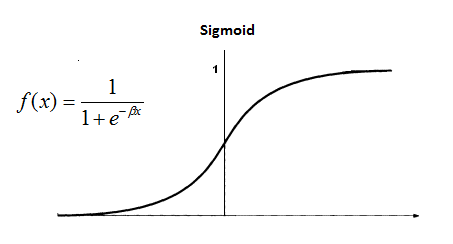

In [ ]:
# model 불러오기
model = LogisticRegression()

# model 학습시키기
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         CCC       0.00      0.00      0.00         0
         ENM       0.00      0.00      0.00         1
         IVF       1.00      1.00      1.00         1
        KUDT       1.00      1.00      1.00         1
        KURC       0.00      0.00      0.00         4
       KUSEP       0.00      0.00      0.00         1
        LECA       0.00      0.00      0.00         0
         SFC       0.00      0.00      0.00         0
         TTP       0.00      0.00      0.00         0
        고란도란       0.00      0.00      0.00         1
       고전기타부       0.80      1.00      0.89         4
         관악부       0.67      1.00      0.80         2
        관현악단       1.00      1.00      1.00         1
       국악연구회       1.00      1.00      1.00         1
        그루터기       0.00      0.00      0.00         1
        뇌의주름       0.50      1.00      0.67         2
       사람과사람       0.00      0.00      0.00         0
        소믈리에       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



##### Logistic Regression (LASSO)

In [ ]:
model = LogisticRegression(penalty='l1', solver='liblinear')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ALC       0.00      0.00      0.00         0
         CCC       0.00      0.00      0.00         0
         ENM       0.00      0.00      0.00         1
         IVF       1.00      1.00      1.00         1
        KUDT       1.00      1.00      1.00         1
        KURC       0.00      0.00      0.00         4
       KUSEP       0.00      0.00      0.00         1
        LECA       0.00      0.00      0.00         0
         TTP       0.00      0.00      0.00         0
        고란도란       0.00      0.00      0.00         1
       고전기타부       1.00      1.00      1.00         4
         관악부       1.00      1.00      1.00         2
        관현악단       0.50      1.00      0.67         1
       국악연구회       1.00      1.00      1.00         1
        그루터기       0.00      0.00      0.00         1
        뇌의주름       0.67      1.00      0.80         2
       사람과사람       0.00      0.00      0.00         0
        소믈리에       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



##### Logistic Regression (Ridge)

In [ ]:
model = LogisticRegression(penalty='l2', solver='liblinear')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ENM       0.00      0.00      0.00         1
         IVF       0.50      1.00      0.67         1
        KUDT       1.00      1.00      1.00         1
        KURC       0.00      0.00      0.00         4
       KUSEP       0.00      0.00      0.00         1
        LECA       0.00      0.00      0.00         0
         SFC       0.00      0.00      0.00         0
         TTP       0.00      0.00      0.00         0
        고란도란       0.00      0.00      0.00         1
       고전기타부       0.80      1.00      0.89         4
         관악부       1.00      1.00      1.00         2
        관현악단       0.00      0.00      0.00         1
       국악연구회       1.00      1.00      1.00         1
        그루터기       0.00      0.00      0.00         1
        뇌의주름       0.50      1.00      0.67         2
       사람과사람       0.00      0.00      0.00         0
        소믈리에       1.00      1.00      1.00         1
        열두루달       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# 변수별 coefficient 확인
feature_importance_lr = pd.DataFrame(zip(X.columns.values, model.coef_.ravel()))
feature_importance_lr.columns = ['feature', 'coef']
feature_importance_lr.sort_values("coef", ascending=False, inplace=True)
feature_importance_lr

,feature,coef
55,자기계발,0.588842
29,활동 강제 정도_반드시 한 번 이상 필참,0.245795
52,선발절차_없음,0.209368
25,추천하는 학년_2,0.207832
27,추천하는 학년_4,0.183552
48,성비_비슷함,0.174262
26,추천하는 학년_3,0.159096
21,행사규모,0.146951
45,공통 주제_없음,0.124556
33,동아리원 실력_아마추어,0.121356


## 2. 의사결정나무 구축

Decision Tree (의사결정나무)

  - 독립 변수의 값에 따라 분기를 태워가며 최적의 분류 모델을 찾는 기법

  - 성장(growing), 가지치기(pruning)를 통해 모델을 생성한다.

    - 분리 기준: 카이제곱 통계량, 지니, 엔트로피 / 분산분석 F 통계량, 분산 감소량

    - 의사결정 알고리즘: CART (범주형: 지니 / 연속형: 분산 감소량), C4.5/5.0 (엔트로피), CHAID (카이제곱 통계량)

    - 정지 기준: maxdepth, minsplit 등 (정지 기준은 여러가지이나 한 개만 제한 요소로 작용하게 해도 hyperparameter 조절 가능, 해당 코드에선 maxdepth 이용)

In [ ]:
# max_depth를 토대로 최적 hyperparameter 구하기

max_depths = [1,3,5,7,9,11,13,15, None] # 변할 수 있음.
train_accuracy = []
test_accuracy = []

for max_depth in max_depths:
    
    # 모델 학습
    model = DecisionTreeClassifier(max_depth=max_depth) 
    model.fit(X_train, y_train)
    
    # 예측
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # 정확도 확인
    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_test_pred))

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


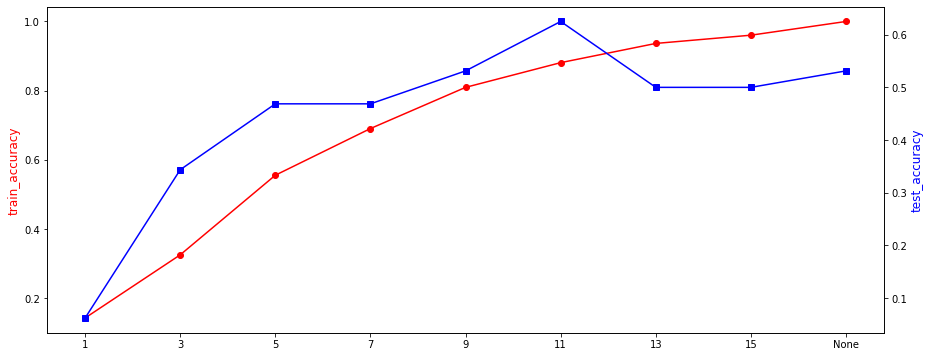

In [ ]:
# train, test accuracy 시각화

fig, ax = plt.subplots(figsize=(15, 6))

xticks = list(map(str, max_depths))

ax.plot(range(len(max_depths)), train_accuracy, color='red', marker='o')
ax.set_ylabel('train_accuracy', color='red', fontsize=12)

ax2 = ax.twinx()
ax2.plot(range(len(max_depths)), test_accuracy, color='blue', marker='s')
ax2.set_ylabel('test_accuracy', color='blue', fontsize=12)

plt.xticks(range(len(max_depths)), xticks)
plt.show()

In [ ]:
model = DecisionTreeClassifier(max_depth=11)
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.59375

## 3. KNN 구축

kNN (K-NN, K-Nearest Neighbor)

  - 데이터의 클래스를 해당 데이터와 가장 가까운 k개 데이터들의 클래스로 결정하는 기법

  - train_data만 있으면 된다. (train data를 기반으로 분류를 수행하기 때문에 모델링이 필요 없다.)

    - 거리 척도: 유클리디안(L2), 맨하탄(L1)

    - k 조건: (1) 홀수 (동률이 나오면 안 됨), (2) 일반적으로 훈련데이터 개수의 제곱근으로 설정

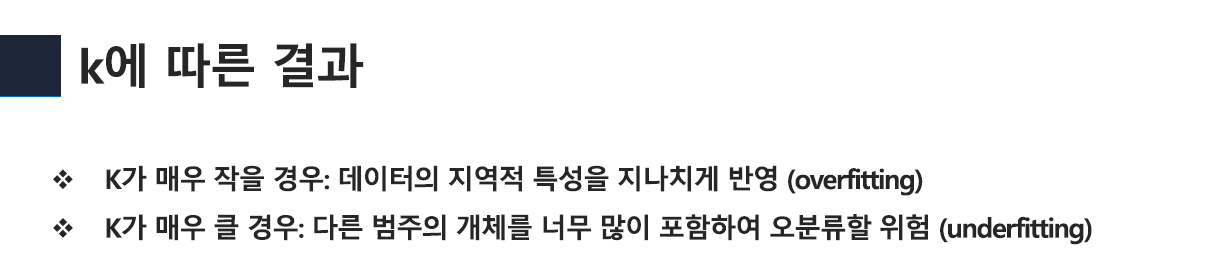

k뿐만 아니라 거리측도의 종류 또한 고려 

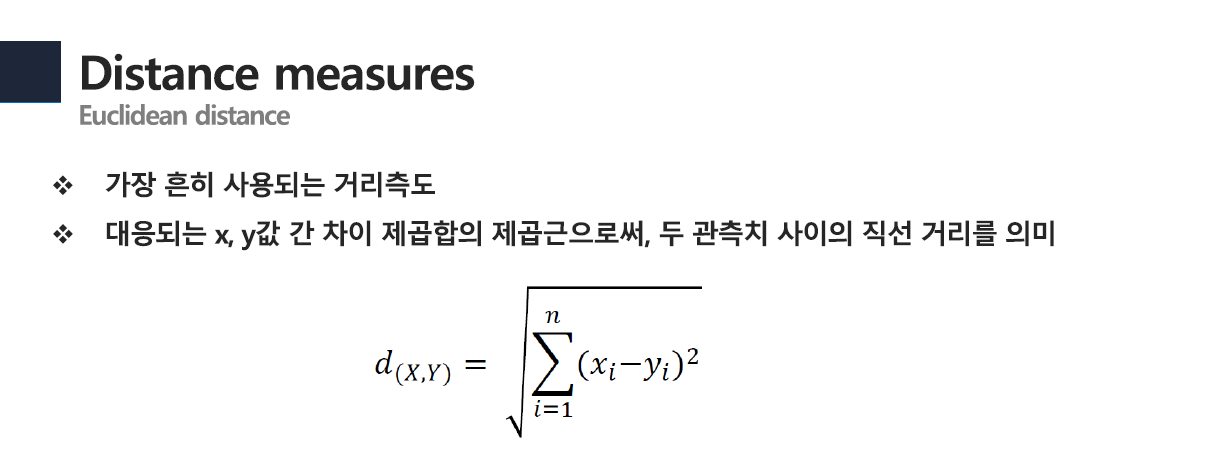

In [ ]:
# 유클리디안
k_list = [i for i in range(1,100) if i%2 !=0]

euc = []
for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k, p=2)  
    scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring = 'accuracy')
    euc.append(scores.mean()) 

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

  8%|▊         | 4/50 [00:00<00:01, 32.34it/s]/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packag

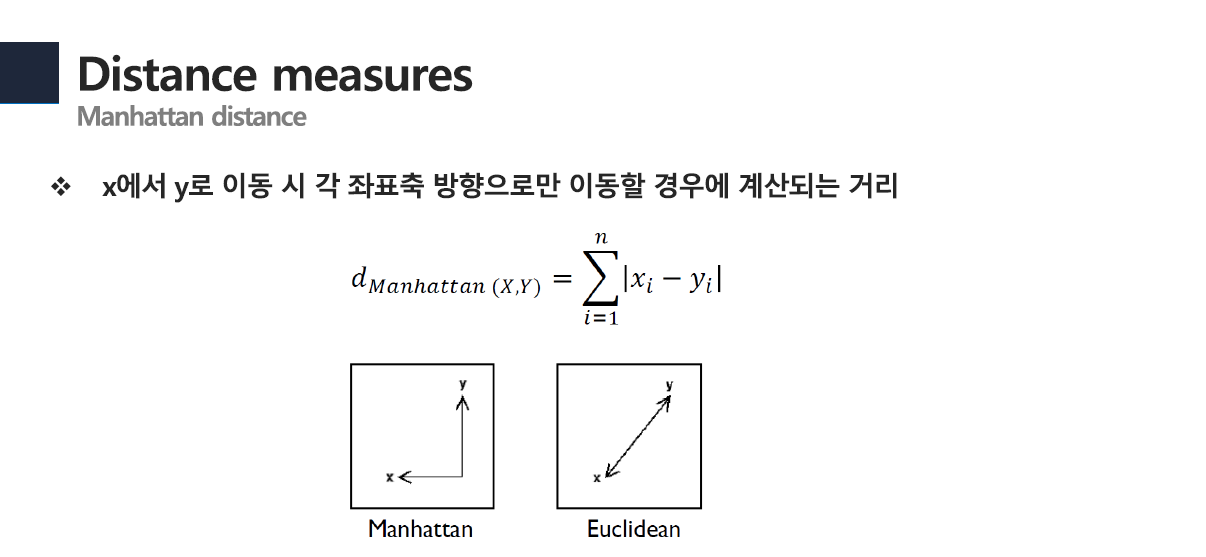

In [ ]:
# 맨해튼
k_list = [i for i in range(1,100) if i%2 !=0]

man = []
for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k, p=1) 
    scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring = 'accuracy')
    man.append(scores.mean()) 

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

  6%|▌         | 3/50 [00:00<00:01, 24.13it/s]/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packag

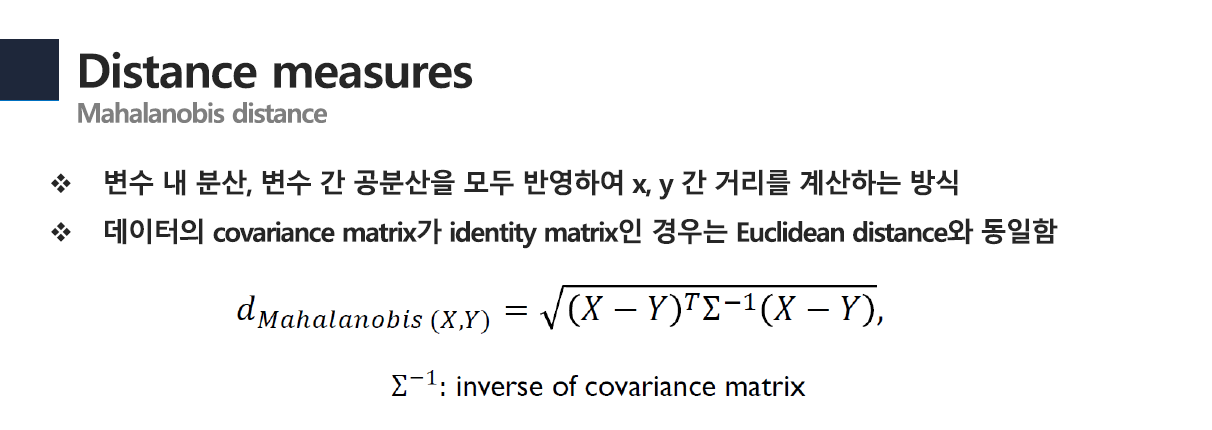

In [ ]:
# 마하라노비스
y_train = y_train.values.ravel()
kf = KFold(n_splits=10)
kf.get_n_splits(X_train)

k_list = [i for i in range(1,100) if i%2 !=0]

mah = []
for k in tqdm(k_list):

# K-fold cross validation
    mah_acc = []
    for train_index, valid_index in kf.split(X_train):
        X_train_f = X_train[train_index]
        y_train_f = y_train[train_index]

        X_valid_f = X_train[valid_index]
        y_valid_f = y_train[valid_index]


        total = len(y_valid_f)
        correct = 0

        nn = NearestNeighbors(algorithm='brute', metric='mahalanobis', 
                              metric_params={'V':np.cov(X_train_f, rowvar=False)}, n_neighbors=k)
        nn_model = nn.fit(X_train_f,y_train_f)


        for v in range(len(X_valid_f)):
            distance, indices = nn_model.kneighbors(X_valid_f[v].reshape(1,-1))

            class_list = {'0':0, '1':0}
            for i in range(len(indices[0])):
                if y_train_f[indices[0][i]] == 0:
                    class_list['0'] +=  1
                else :
                    class_list['1'] += 1

            max_key = np.int(max(class_list, key=class_list.get))
            if max_key == y_valid_f[v]:
                correct += 1

        mah_acc.append(correct/total)
        
    mah.append(np.mean(mah_acc))

100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


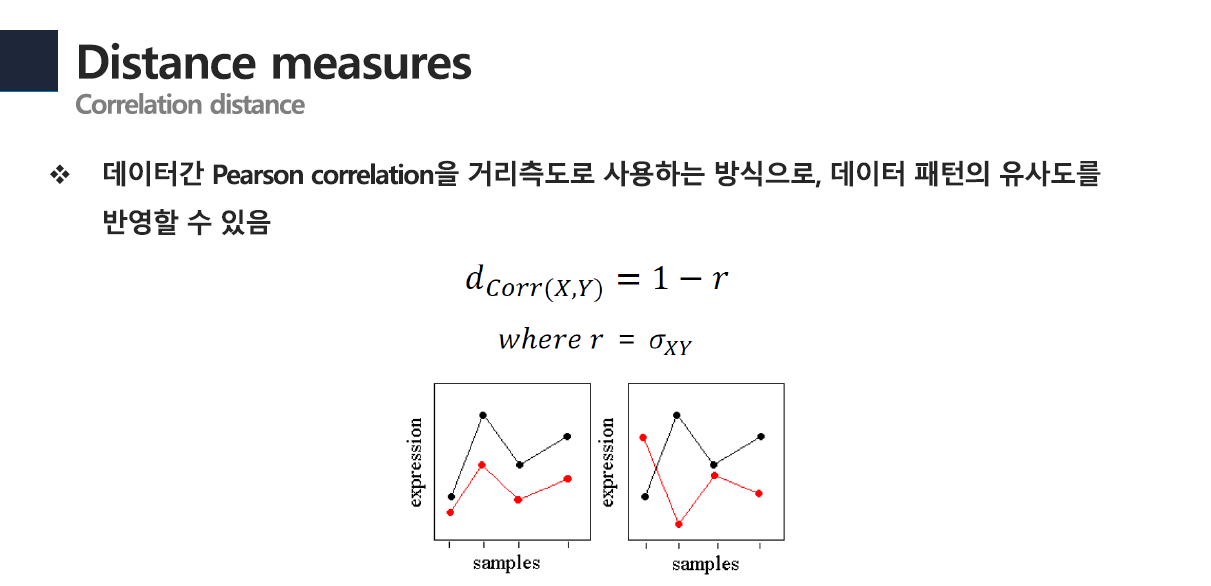

In [ ]:
# pearson correlation
kf = KFold(n_splits=10)
kf.get_n_splits(X_train)

k_list = [i for i in range(1,100) if i%2 !=0]

pear = []
for k in tqdm(k_list):

# K-fold cross validation
    pear_acc = []
    for train_index, valid_index in kf.split(X_train):
        X_train_f = X_train[train_index]
        y_train_f = y_train[train_index]

        X_valid_f = X_train[valid_index]
        y_valid_f = y_train[valid_index]


        total = len(y_valid_f)
        correct = 0

        nn = NearestNeighbors(metric='correlation', n_neighbors=k)
        nn_model = nn.fit(X_train_f,y_train_f)


        for v in range(len(X_valid_f)):
            distance, indices = nn_model.kneighbors(X_valid_f[v].reshape(1,-1))

            class_list = {'0':0, '1':0}
            for i in range(len(indices[0])):
                if y_train_f[indices[0][i]] == 0:
                    class_list['0'] += 1
                else :
                    class_list['1'] += 1

            max_key = np.int(max(class_list, key=class_list.get))
            if max_key == y_valid_f[v]:
                correct += 1

        pear_acc.append(correct/total)
        
    pear.append(np.mean(pear_acc))

100%|██████████| 50/50 [00:03<00:00, 16.49it/s]


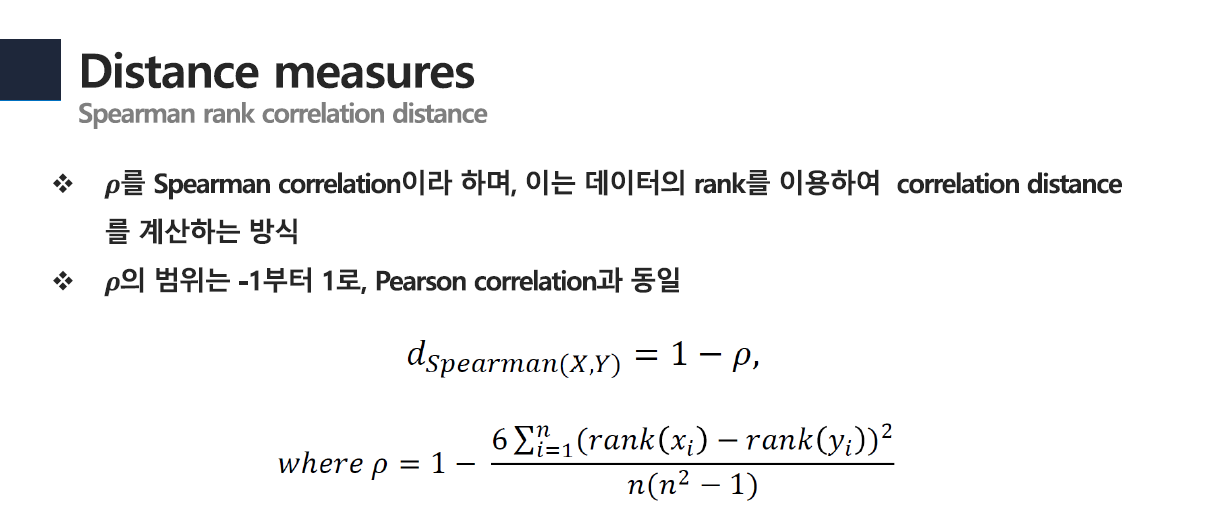

In [ ]:
# spearman rank correlation
def spearmancorr(x,y):
    rho, pval = spearmanr(x, y, axis=0)
    return 1-rho

kf = KFold(n_splits=10)
kf.get_n_splits(X_train)

k_list = [i for i in range(1,100) if i%2 !=0]

spear = []
for k in tqdm(k_list):

# K-fold cross validation
    spear_acc = []
    for train_index, valid_index in kf.split(X_train):
        X_train_f = X_train[train_index]
        y_train_f = y_train[train_index]

        X_valid_f = X_train[valid_index]
        y_valid_f = y_train[valid_index]


        total = len(y_valid_f)
        correct = 0

        nn = NearestNeighbors(metric = spearmancorr, n_neighbors=k, algorithm='ball_tree')
        nn_model = nn.fit(X_train_f,y_train_f)

        for v in range(len(X_valid_f)):
            distance, indices = nn_model.kneighbors(X_valid_f[v].reshape(1,-1))

            class_list = {'0':0, '1':0}
            for i in range(len(indices[0])):
                if y_train_f[indices[0][i]] == 0:
                    class_list['0'] += 1
                else :
                    class_list['1'] += 1

            max_key = np.int(max(class_list, key=class_list.get))
            if max_key == y_valid_f[v]:
                correct += 1

        spear_acc.append(correct/total)
    spear.append(np.mean(spear_acc))

100%|██████████| 50/50 [09:02<00:00, 10.85s/it]


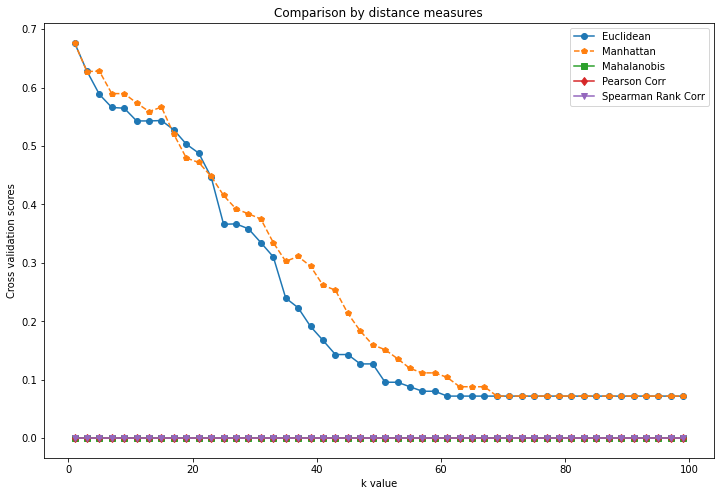

In [ ]:
# k값과 거리측도에 따른 정확도 시각화

plt.figure(figsize=(12,8))
# plt.plot(k_list, acc_spear, marker='o', linestyle='dashed')
plt.plot(k_list, euc, marker='o')
plt.plot(k_list, man, linestyle='dashed', marker='p')
plt.plot(k_list, mah, marker='s')
plt.plot(k_list, pear, marker='d')
plt.plot(k_list, spear, marker='v')
plt.xlabel("k value")
plt.ylabel("Cross validation scores")
plt.title("Comparison by distance measures")
plt.legend(["Euclidean","Manhattan","Mahalanobis","Pearson Corr","Spearman Rank Corr"])
plt.show()

- 일반적으로 유클리디언과 맨해튼 거리 기법이 높은 성능을 기록하는데, 해당 데이터셋에도 같은 특징을 보였다.
- 해당 데이터셋의 상관관계의 고려가 크게 필요하지 않음을 원인으로 예측했다.

In [ ]:
# 최적값인 manhattan 거리기법과 k=5 적용
y_train = y_train.astype('str')
y_test = y_test.astype('str')
classifier = KNeighborsClassifier(n_neighbors = 5, p=1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ALC       0.00      0.00      0.00         0
         CCC       0.00      0.00      0.00         0
         ENM       0.00      0.00      0.00         1
         IVF       0.50      1.00      0.67         1
        KUDT       1.00      1.00      1.00         1
        KURC       0.00      0.00      0.00         4
       KUSEP       1.00      1.00      1.00         1
         TTP       0.00      0.00      0.00         0
        고란도란       0.00      0.00      0.00         1
       고전기타부       0.80      1.00      0.89         4
         관악부       0.50      1.00      0.67         2
        관현악단       0.00      0.00      0.00         1
       국악연구회       0.00      0.00      0.00         1
        그루터기       0.00      0.00      0.00         1
        뇌의주름       0.50      1.00      0.67         2
       사람과사람       0.00      0.00      0.00         0
        소믈리에       1.00      1.00      1.00         1
        열두루달       0.00    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



##### Weighted K-NN 구축 ( 각 거리값을 model train에 가중치로 반영하는 방법 )

  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/

Best k value :  [3]


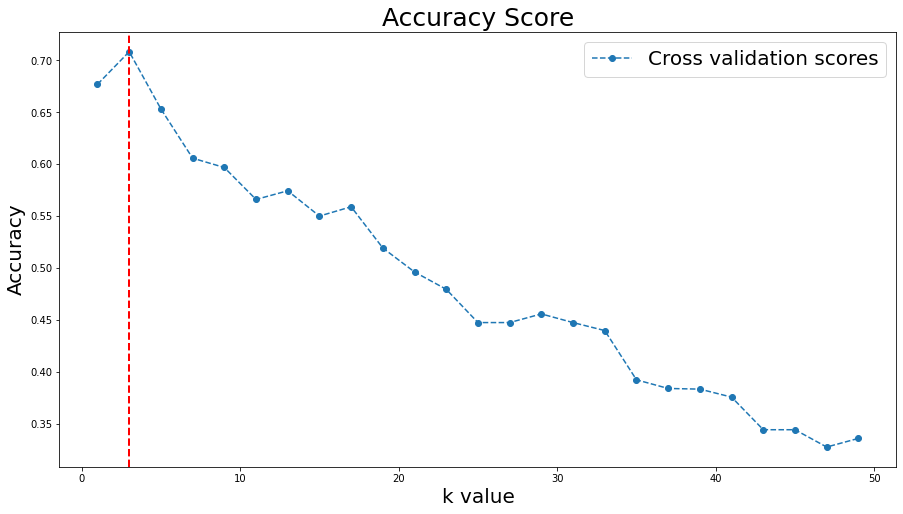

In [ ]:
# weighted K-NN
k_list = [i for i in range(1,50) if i%2 !=0]
euc = []
for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k, p=2, weights='distance') # weights{‘uniform’, distance’} or callable, 
                                                                                # default=’uniform’
    scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring = 'accuracy')
    euc.append(scores.mean()) 
    
best_k = [k_list[i] for i in range(len(euc)) if euc[i] == np.max(euc)]
print("Best k value : ", best_k)
plt.figure(figsize=(15,8))
plt.plot(k_list, euc, marker='o', linestyle='dashed')
plt.legend(["Cross validation scores"], fontsize=20)
plt.xlabel("k value", fontsize=20 )
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy Score", fontsize=25)
plt.axvline(best_k[0], color='r', linestyle='--', linewidth=2)
plt.show()

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 3, p=2, weights='distance')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ATP       0.00      0.00      0.00         0
         CCC       0.00      0.00      0.00         0
         ENM       0.00      0.00      0.00         1
         IVF       1.00      1.00      1.00         1
        KUDT       1.00      1.00      1.00         1
        KURC       0.00      0.00      0.00         4
       KUSEP       0.00      0.00      0.00         1
        LECA       0.00      0.00      0.00         0
         SFC       0.00      0.00      0.00         0
         TTP       0.00      0.00      0.00         0
        고란도란       0.00      0.00      0.00         1
       고전기타부       0.57      1.00      0.73         4
         관악부       0.67      1.00      0.80         2
        관현악단       0.00      0.00      0.00         1
       국악연구회       1.00      1.00      1.00         1
        그루터기       0.00      0.00      0.00         1
        뇌의주름       0.50      1.00      0.67         2
       사람과사람       0.00    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



## 4. Random Forest 구축

Random Forest
- 훈련을 통해 구성해놓은 다수의 Decision Tree들로부터 분류 결과를 취합해서 결론을 얻는 방법

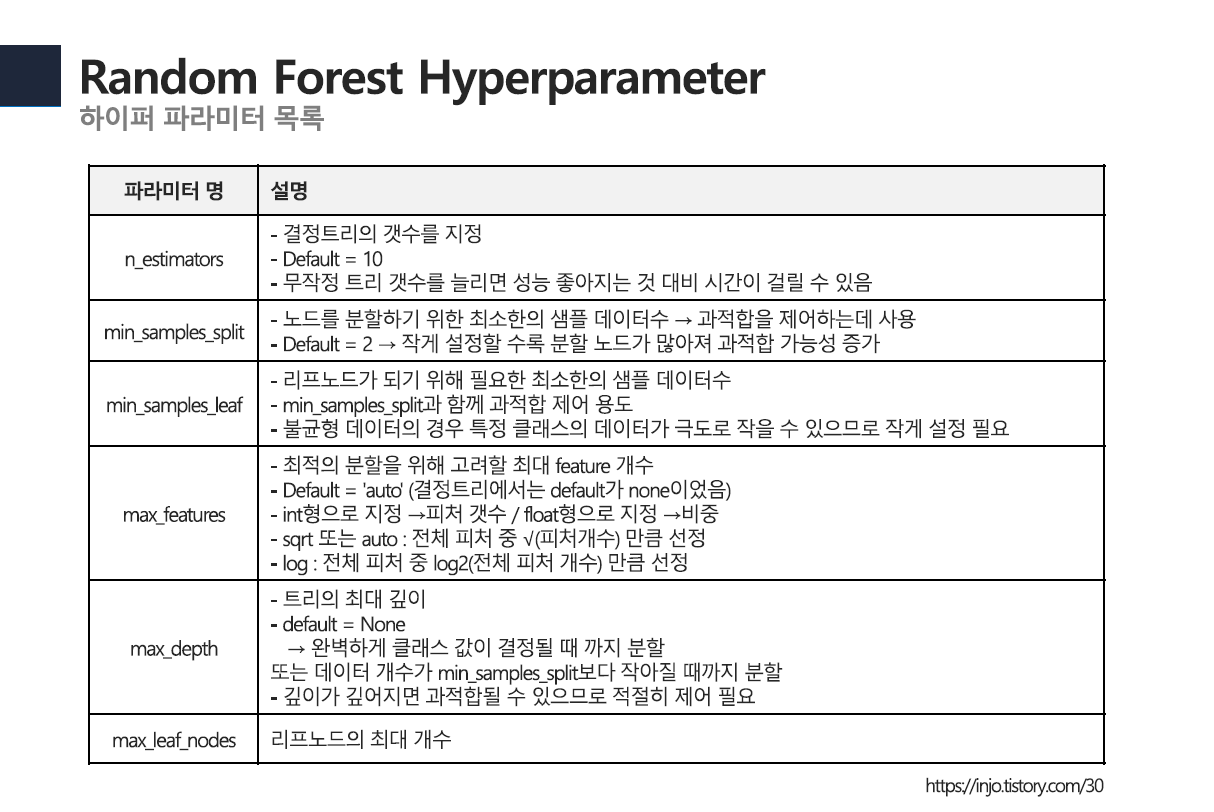

In [ ]:
# Train set/ Test set 나누기
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,  #  train set: test set을 4:1로 훈련, 테스트셋 분리
                                                   random_state=2021) # stratify = y
# 데이터 컬럼 단위 정규화 하기 
# 각 변수들의 max,min 값이 다르기 때문에 값이 큰 변수들일수록 모델에 영향을 크게 미치기 때문에 모든 변수의 범위를 일정하게 조절
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

print(f'Train set dimension is {X_train.shape}')
print(f'Test set dimension is {X_test.shape}')

Train set dimension is (126, 60)
Test set dimension is (32, 60)


In [ ]:
# 전체 하이퍼 파라미터에 대한 Grid search (파라미터 최적화) : 대강 숫자를 잡은 후 세분화하며 accuracy 비교
rfc = RandomForestClassifier(random_state=2021)
param_grid = {
    'n_estimators': [50, 60, 70],
    'max_depth': [10,15,20],
    'max_leaf_nodes': [50, 100, 200],
    'criterion':['gini', 'entropy'],
    'max_features':['auto','sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, verbose=1 ,n_jobs=12)
CV_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    9.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   23.3s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   45.9s
[Parallel(n_jobs=12)]: Done 486 out of 486 | elapsed:   51.0s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': 50,
 'n_estimators': 50}

In [ ]:
rfc = RandomForestClassifier(random_state=2021)
param_grid = {
    'n_estimators': [30,40,50],
    'max_depth': [4,6,8,10],
    'max_leaf_nodes': [30,40,50],
    'criterion':['gini', 'entropy'],
    'max_features':['auto','sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, verbose=1 ,n_jobs=12)
CV_rfc.fit(X_train, y_train)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    9.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   20.6s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   37.9s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:  1.0min
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 2160 out of 2160 | elapsed:  2.7min finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [ ]:
# 최적의 하이퍼 파라미터 셋
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': 40,
 'n_estimators': 40}

In [ ]:
result_table = pd.DataFrame(CV_rfc.cv_results_)
result_table = result_table.sort_values(by='mean_test_score', ascending=False)
print(result_table[['params', 'mean_test_score']])

                                                params  mean_test_score
58   {'criterion': 'gini', 'max_depth': 8, 'max_fea...         0.772436
67   {'criterion': 'gini', 'max_depth': 8, 'max_fea...         0.772436
86   {'criterion': 'gini', 'max_depth': 10, 'max_fe...         0.772436
95   {'criterion': 'gini', 'max_depth': 10, 'max_fe...         0.772436
98   {'criterion': 'gini', 'max_depth': 10, 'max_fe...         0.764744
..                                                 ...              ...
129  {'criterion': 'entropy', 'max_depth': 4, 'max_...         0.598077
132  {'criterion': 'entropy', 'max_depth': 4, 'max_...         0.598077
21   {'criterion': 'gini', 'max_depth': 4, 'max_fea...         0.588462
18   {'criterion': 'gini', 'max_depth': 4, 'max_fea...         0.588462
24   {'criterion': 'gini', 'max_depth': 4, 'max_fea...         0.588462

[216 rows x 2 columns]


In [ ]:
best_rfc = CV_rfc.best_estimator_
best_rfc.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=40, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=2021,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = best_rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ALC       0.00      0.00      0.00         0
         ECS       0.00      0.00      0.00         0
         ENM       0.00      0.00      0.00         1
         IVF       1.00      1.00      1.00         1
        KUBC       0.00      0.00      0.00         0
        KUDT       1.00      1.00      1.00         1
        KURC       0.00      0.00      0.00         4
       KUSEP       1.00      1.00      1.00         1
        고란도란       0.00      0.00      0.00         1
       고전기타부       1.00      1.00      1.00         4
         관악부       1.00      1.00      1.00         2
        관현악단       1.00      1.00      1.00         1
       국악연구회       1.00      1.00      1.00         1
        그루터기       0.00      0.00      0.00         1
        뇌의주름       0.50      1.00      0.67         2
       사람과사람       0.00      0.00      0.00         0
        소믈리에       0.33      1.00      0.50         1
        열두루달       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [ ]:
y_pred

array(['ALC', '젊은예수', '사람과사람', 'IVF', '고전기타부', '소믈리에', '고전기타부', '고전기타부',
       'KUBC', '관악부', '호우회', '뇌의주름', '뇌의주름', '뇌의주름', '운화회', '관현악단',
       'KUDT', '크림슨', '호영회', '뇌의주름', 'ALC', '국악연구회', '운화회', 'ECS',
       'KUSEP', '고전기타부', '소믈리에', '소믈리에', '관악부', '운화회', '원불교학생회',
       '한국사회연구회'], dtype=object)

다양한 동아리에 대해 0.66의 정확도로 예측할 수 있다.

#### 중요변수 추출 코드

In [ ]:
X_feature_names = X.columns.tolist()

In [ ]:
feats = {}
for feature, importance in zip(X_feature_names, best_rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
display(importances)

,Features,Gini-Importance
0,행사규모,0.079658
1,회비,0.069954
2,활동기간,0.051556
3,학과구성,0.042936
4,성비_비슷함,0.031930
5,공연,0.030767
6,취미,0.030529
7,활동적인 부원들,0.025801
8,성비_남자 비율이 높음,0.025790
9,선발절차_없음,0.024685


##### Boruta 변수선택

In [ ]:
X_ = np.array(X)
# Boruta feature selection 기법
feat_selector = BorutaPy(best_rfc, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X_, y)

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X_)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	60
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	60
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	60
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	60
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	60
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	60
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	60
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	23
Tentative: 	13
Rejected: 	24
Iteration: 	9 / 100
Confirmed: 	23
Tentative: 	13
Rejected: 	24
Iteration: 	10 / 100
Confirmed: 	23
Tentative: 	13
Rejected: 	24
Iteration: 	11 / 100
Confirmed: 	23
Tentative: 	13
Rejected: 	24
Iteration: 	12 / 100
Confirmed: 	23
Tentative: 	13
Rejected: 	24
Iteration: 	13 / 100
Confirmed: 	23
Tentative: 	13
Rejected: 	24
Iteration: 	14 / 100
Confirmed: 	23
Tentative: 	12
Rejected: 	25
Iteration: 	15 / 100
Confirmed: 	23
Tentative: 	12
Rejected: 	25
Iteration: 	16 / 100
Confirmed: 	24
Tentative: 	

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_filtered,
                                                   y,
                                                   test_size=0.2,  # train set: test set을 4:1로 훈련, 테스트셋 분리
                                                   random_state=2021)

In [ ]:
rfc = RandomForestClassifier(random_state=2021)
param_grid = {
    'n_estimators': [20,30,40],
    'max_depth': [4,6,8,10],
    'max_leaf_nodes': [20, 30,40],
    'criterion':['gini', 'entropy'],
    'max_features':['auto','sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, verbose=1 ,n_jobs=12)
CV_rfc.fit(X_train2, y_train2)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done 224 tasks      | elapsed:   10.6s
[Parallel(n_jobs=12)]: Done 474 tasks      | elapsed:   23.5s
[Parallel(n_jobs=12)]: Done 824 tasks      | elapsed:   40.9s
[Parallel(n_jobs=12)]: Done 1274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1824 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 2160 out of 2160 | elapsed:  1.8min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [ ]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': 30,
 'n_estimators': 30}

In [ ]:
best_rfc = CV_rfc.best_estimator_
best_rfc.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=30, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=2021,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = best_rfc.predict(X_test2)
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

         ALC       0.00      0.00      0.00         0
         ENM       0.00      0.00      0.00         1
         IVF       0.33      1.00      0.50         1
        KUDT       1.00      1.00      1.00         1
       KULAX       0.00      0.00      0.00         0
        KURC       0.00      0.00      0.00         4
       KUSEP       1.00      1.00      1.00         1
         SFC       0.00      0.00      0.00         0
       TERRA       0.00      0.00      0.00         0
         TTP       0.00      0.00      0.00         0
        고란도란       0.00      0.00      0.00         1
       고전기타부       1.00      1.00      1.00         4
         관악부       1.00      1.00      1.00         2
        관현악단       1.00      1.00      1.00         1
       국악연구회       1.00      1.00      1.00         1
        그루터기       0.00      0.00      0.00         1
        뇌의주름       1.00      1.00      1.00         2
        소믈리에       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



## 5. Boosting 계열 구축

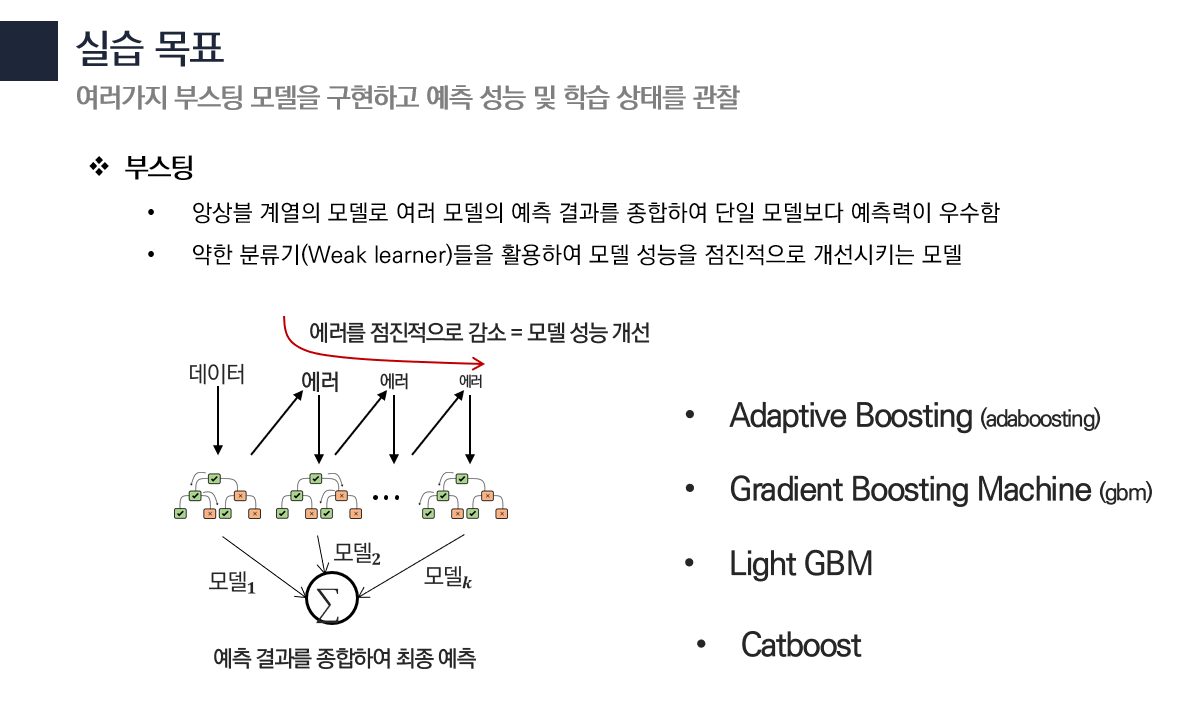

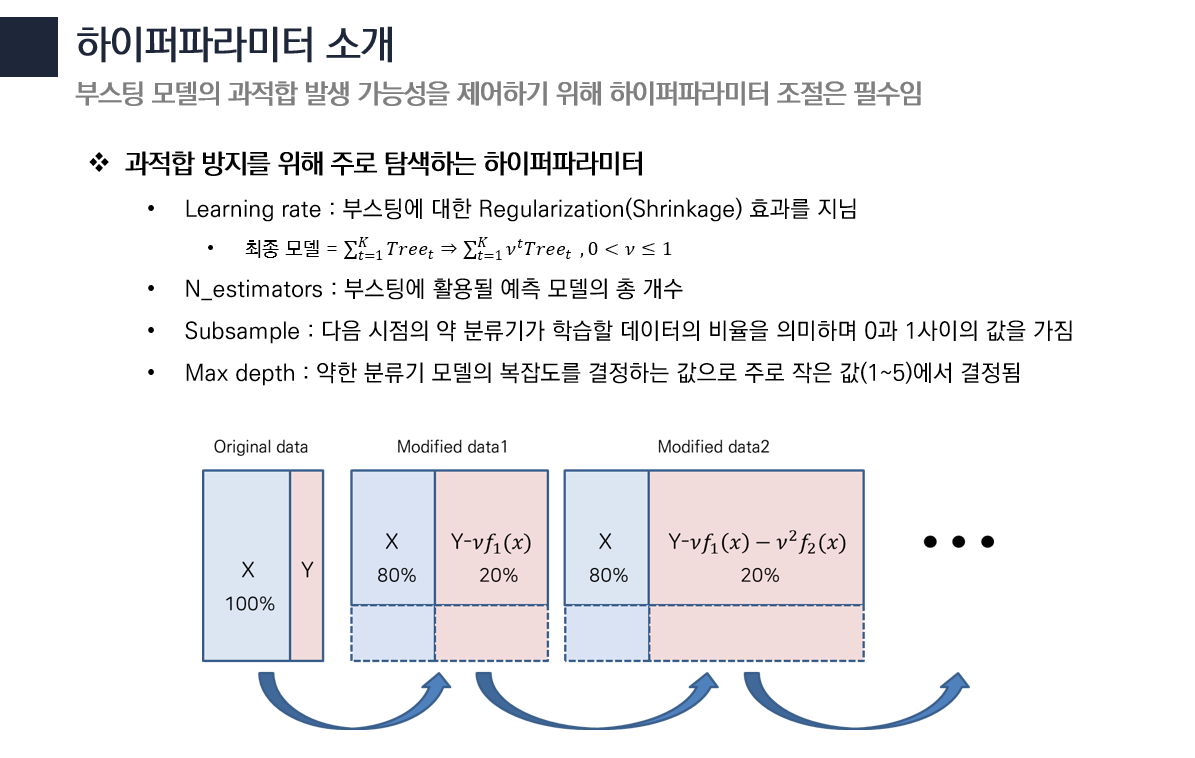

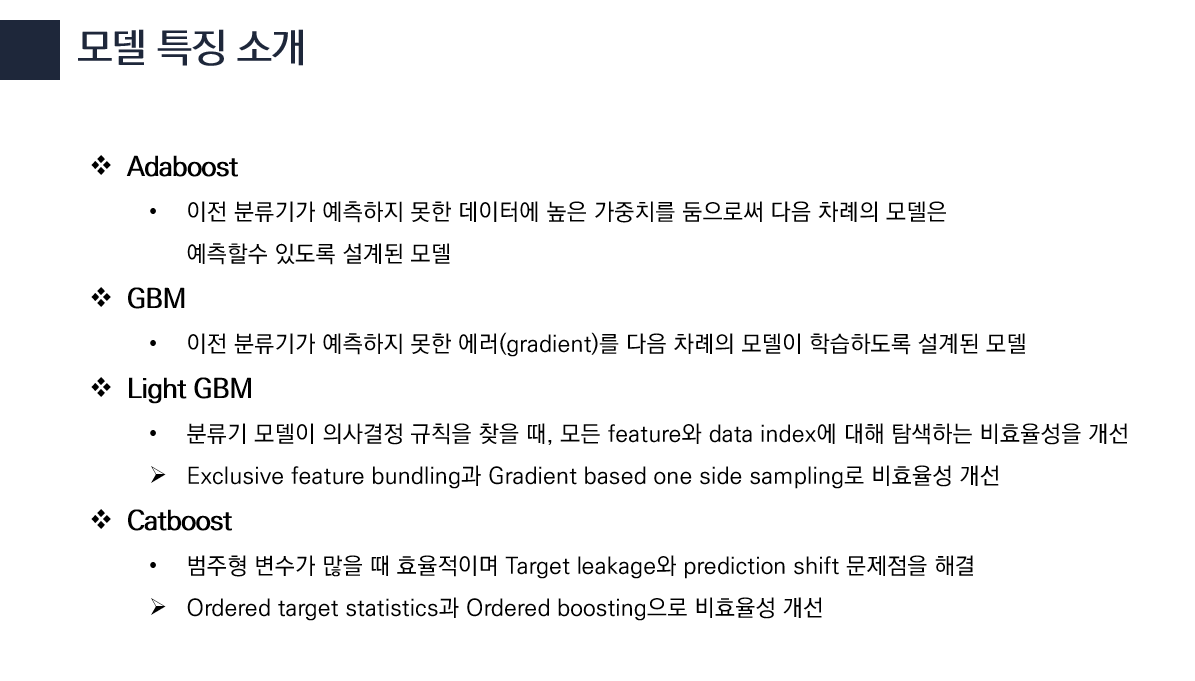

In [ ]:
device = torch.cuda.is_available() 

## 탐색하고자 하는 하이퍼파라미터 설정 ## 
model_params = {"GBM": {'model': GradientBoostingClassifier(random_state=0), # 그레디언트 부스팅
                        'params': { 'learning_rate': [0.2*(i+1) for i in range(3)], # 학습률, Shrinkage율
                                    'n_estimators': [50*(i+1) for i in range(3)] , 
                                    'subsample':[0.5,0.75,1.0],
                                    'max_depth':[i for i in range(1,11,2)]
                                  }},

                "AdaBoost": {'model': AdaBoostClassifier(random_state=0),# 에이다 부스팅
                        'params': {'base_estimator':  [DecisionTreeClassifier(max_depth=i) for i in range(1,11,2)], # 약분류기 (주로 의사결정나무를 사용)
                                   'n_estimators':[50*(i+1) for i in range(3)], 
                                   'learning_rate':[0.2*(i+1) for i in range(3)]}},
                
                'Light GBM' : {'model' : LGBMClassifier(random_state=0, silent=True, device='gpu') \
                               if device == True else LGBMClassifier(random_state=0, silent=True),
                          'params' : {'max_depth':[i for i in range(1,11,2)],
                                      'n_estimators':[50*(i+1) for i in range(3)],
                                      'learning_rate': [0.2*(i+1) for i in range(3)]
                                     }},
                
                'Catboost' : {'model' : CatBoostClassifier(random_seed=0, silent=True, task_type = 'GPU', thread_count = 5 , gpu_ram_part = .5) \
                              if device == True else CatBoostClassifier(random_seed=0, silent=True), 
                              'params' : {'max_depth':[i for i in range(1,11,2)] ,
                                          'n_estimators':[50*(i+1) for i in range(3)],
                                          'learning_rate': [0.2*(i+1) for i in range(3)]
                                     }}
                                    }

In [ ]:
y_train = y_train.astype('str')
y_test = y_test.astype('str')

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.25,
                                                   random_state=2021,)
# 데이터 컬럼 단위 정규화 하기 
# 각 변수들의 max,min 값이 다르기 때문에 값이 큰 변수들일수록 모델에 영향을 크게 미치기 때문에 모든 변수의 범위를 일정하게 조절
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)


In [ ]:
# seeds = [0 for i in range(10)]
seeds = [0]
pbar = tqdm(total=len(model_params)*len(seeds)) # tqdm은 학습 상태가 어느정도 됬는지 파악해주는데 유용한 함수입니다.
output = pd.DataFrame([]) # 학습 결과를 저장하기 위한 객체 생성


for seed in seeds:
    
    # 4가지 모델에 대한 학습 시작 # 
    for model_name, v in model_params.items():

        pbar.set_description(desc=f"{model_name}") # tqdm에서 활용되는 옵션입니다. 현재 학습되고 있는 모델 이름을 출력합니다.
        
        model, params = v['model'], v['params']
        gcv = GridSearchCV(estimator=model, param_grid=params, n_jobs=2 if model_name == 'Catboost' else 5, cv=5, scoring='accuracy')
        gcv.fit(X_train, y_train)
        
        result = pd.DataFrame.from_dict(gcv.cv_results_) # cv_results에는 각 fold별 예측 성능이 기록되어 있습니다.
        result['test_accuracy_with_best_hyp'] = accuracy_score(y_pred = gcv.predict(X_test) , y_true = y_test) #gcv.predict()는 최적 하이퍼파라미터가 탑재된 모델의 예측 결과를 파악하는데 사용됩니다.
        result['model_name'] = model_name
        result['seed'] = seed
        output = pd.concat([output,result])
        pbar.update(1)

output.reset_index(drop=True)       

GBM:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

AdaBoost:  25%|██▌       | 1/4 [23:14<1:09:43, 1394.39s/it]/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

Light GBM:  50%|█████     | 2/4 [24:06<33:03, 991.74s/it]/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

Catboost:  75%|███████▌  | 3/4 [25:02<11:51, 711.05s/it] /usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691:

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,test_accuracy_with_best_hyp,model_name,seed,param_base_estimator
0,5.323722,0.183541,0.004033,0.000760,0.2,1,50,0.5,"{'learning_rate': 0.2, 'max_depth': 1, 'n_esti...",0.208333,0.083333,0.041667,0.086957,0.043478,0.092754,0.060859,118,0.625,GBM,0,NaN
1,5.569713,0.221988,0.008138,0.005802,0.2,1,50,0.75,"{'learning_rate': 0.2, 'max_depth': 1, 'n_esti...",0.000000,0.083333,0.000000,0.173913,0.173913,0.086232,0.077790,121,0.625,GBM,0,NaN
2,5.550967,0.283725,0.007603,0.004921,0.2,1,50,1,"{'learning_rate': 0.2, 'max_depth': 1, 'n_esti...",0.750000,0.666667,0.541667,0.652174,0.695652,0.661232,0.068516,1,0.625,GBM,0,NaN
3,10.761687,0.408144,0.011562,0.003129,0.2,1,100,0.5,"{'learning_rate': 0.2, 'max_depth': 1, 'n_esti...",0.208333,0.083333,0.041667,0.086957,0.043478,0.092754,0.060859,118,0.625,GBM,0,NaN
4,11.013160,0.285292,0.021186,0.008087,0.2,1,100,0.75,"{'learning_rate': 0.2, 'max_depth': 1, 'n_esti...",0.000000,0.083333,0.000000,0.173913,0.173913,0.086232,0.077790,121,0.625,GBM,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,14.874484,0.473524,0.007729,0.002852,0.6,7,100,NaN,"{'learning_rate': 0.6000000000000001, 'max_dep...",0.791667,0.750000,0.666667,0.739130,0.782609,0.746014,0.044233,18,0.700,Catboost,0,NaN
266,22.385195,0.684504,0.011724,0.004776,0.6,7,150,NaN,"{'learning_rate': 0.6000000000000001, 'max_dep...",0.791667,0.750000,0.666667,0.739130,0.782609,0.746014,0.044233,18,0.700,Catboost,0,NaN
267,26.996736,1.108942,0.012099,0.001420,0.6,9,50,NaN,"{'learning_rate': 0.6000000000000001, 'max_dep...",0.791667,0.750000,0.666667,0.739130,0.739130,0.737319,0.040281,26,0.700,Catboost,0,NaN
268,54.830897,1.582792,0.009205,0.002387,0.6,9,100,NaN,"{'learning_rate': 0.6000000000000001, 'max_dep...",0.791667,0.750000,0.666667,0.739130,0.782609,0.746014,0.044233,18,0.700,Catboost,0,NaN


#### 하이퍼파라미터 종류별 예측 성능에 대한 영향을 개략적으로 시각화한 코드


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


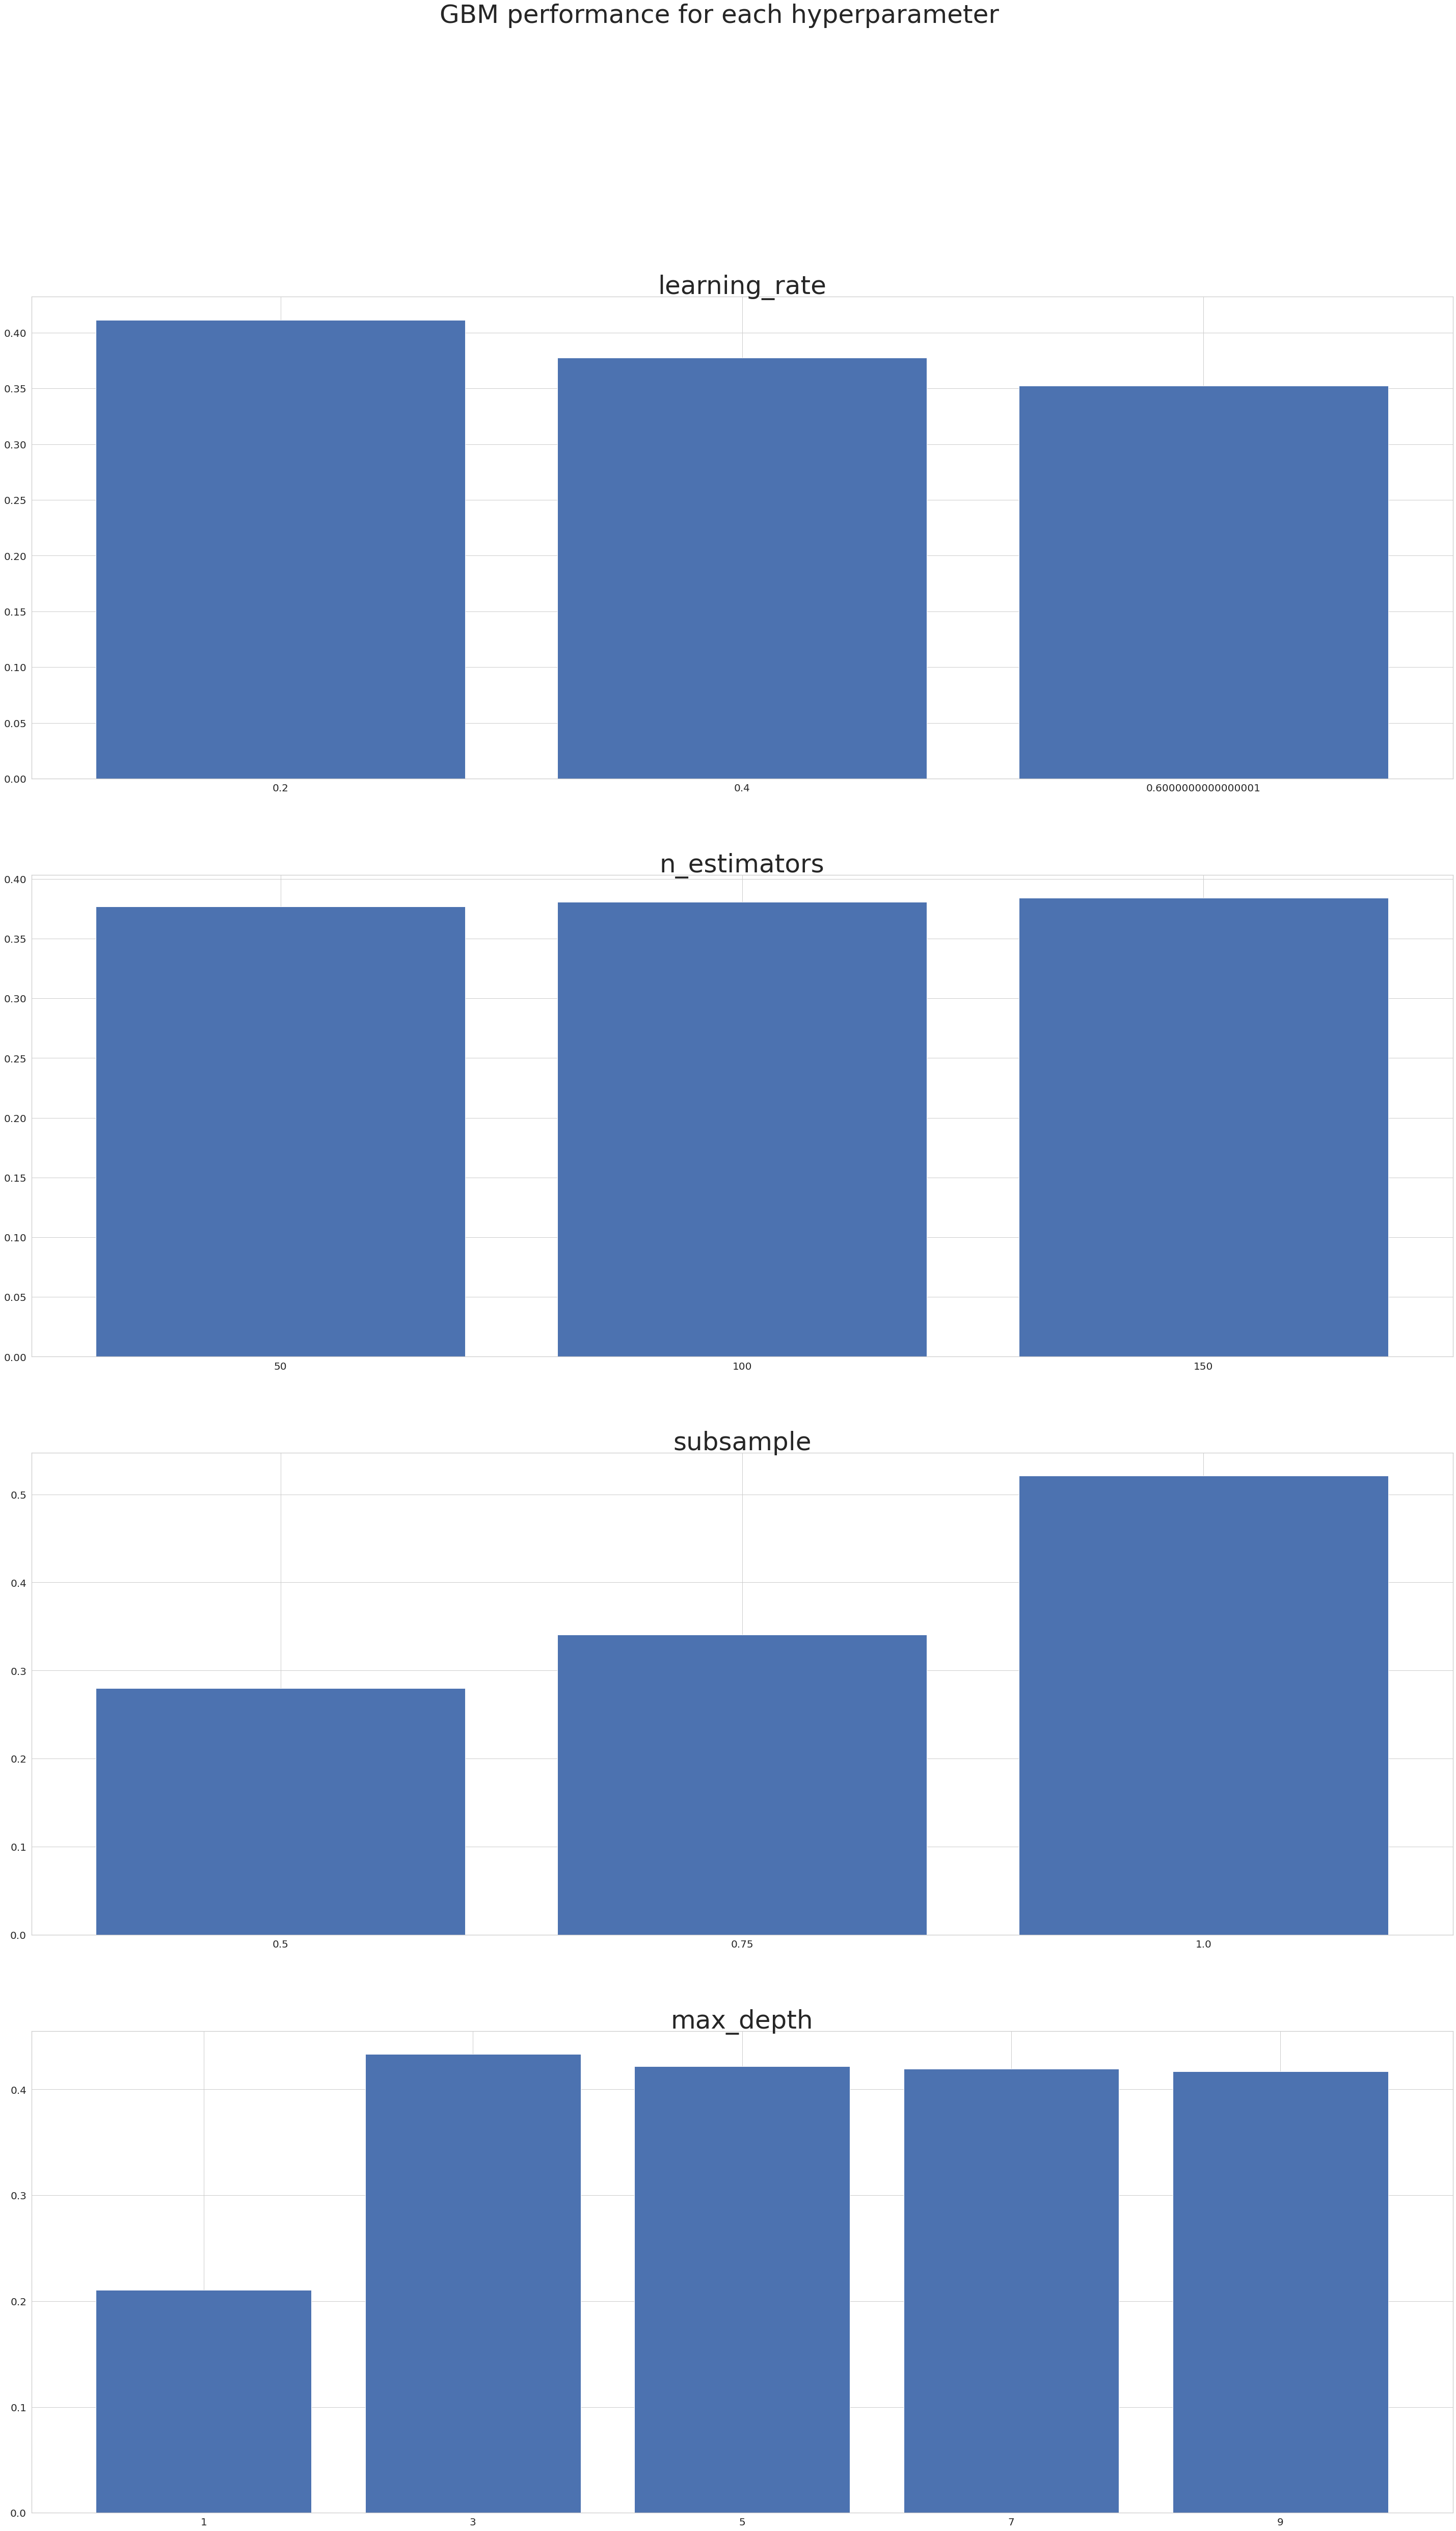

In [ ]:
model_name = 'GBM' # GBM , AdaBoost, Light GBM, Catboost

for_plot_values = output.loc[ output['model_name'] == model_name,:] # 예측 모델별 결과 확인을 위한 indexing

fig , axs = plt.subplots(nrows=model_params[model_name]['params'].keys().__len__(), ncols=1, figsize=(50,80)) # plot configure
fig.suptitle(f'{model_name} performance for each hyperparameter',fontsize=50) # 전체 Plot 제목

for ind , param_key in enumerate(model_params[model_name]['params'].keys()):
    
    param_for_plot = for_plot_values.groupby([f'param_{param_key}'])['mean_test_score'].mean() # 조절 하이퍼파라미터 이외에 대해서는 평균 성능 (개략적)
    
    axs[ind].bar(height = param_for_plot.values,x = [i for i in range(param_for_plot.values.shape[0])]) # bar plot 
    axs[ind].tick_params(axis='both',labelsize=20) # x,y 축 글씨 폰트 설정
    
    axs[ind].set_xticks([i for i in range(param_for_plot.values.shape[0])]) # x 축 ticks 설정
    axs[ind].set_xticklabels(param_for_plot.index.to_list()) # x 축 ticks 이름 설정

    axs[ind].set_title(f'{param_key}',fontsize=50) # 내부 plot 제목 

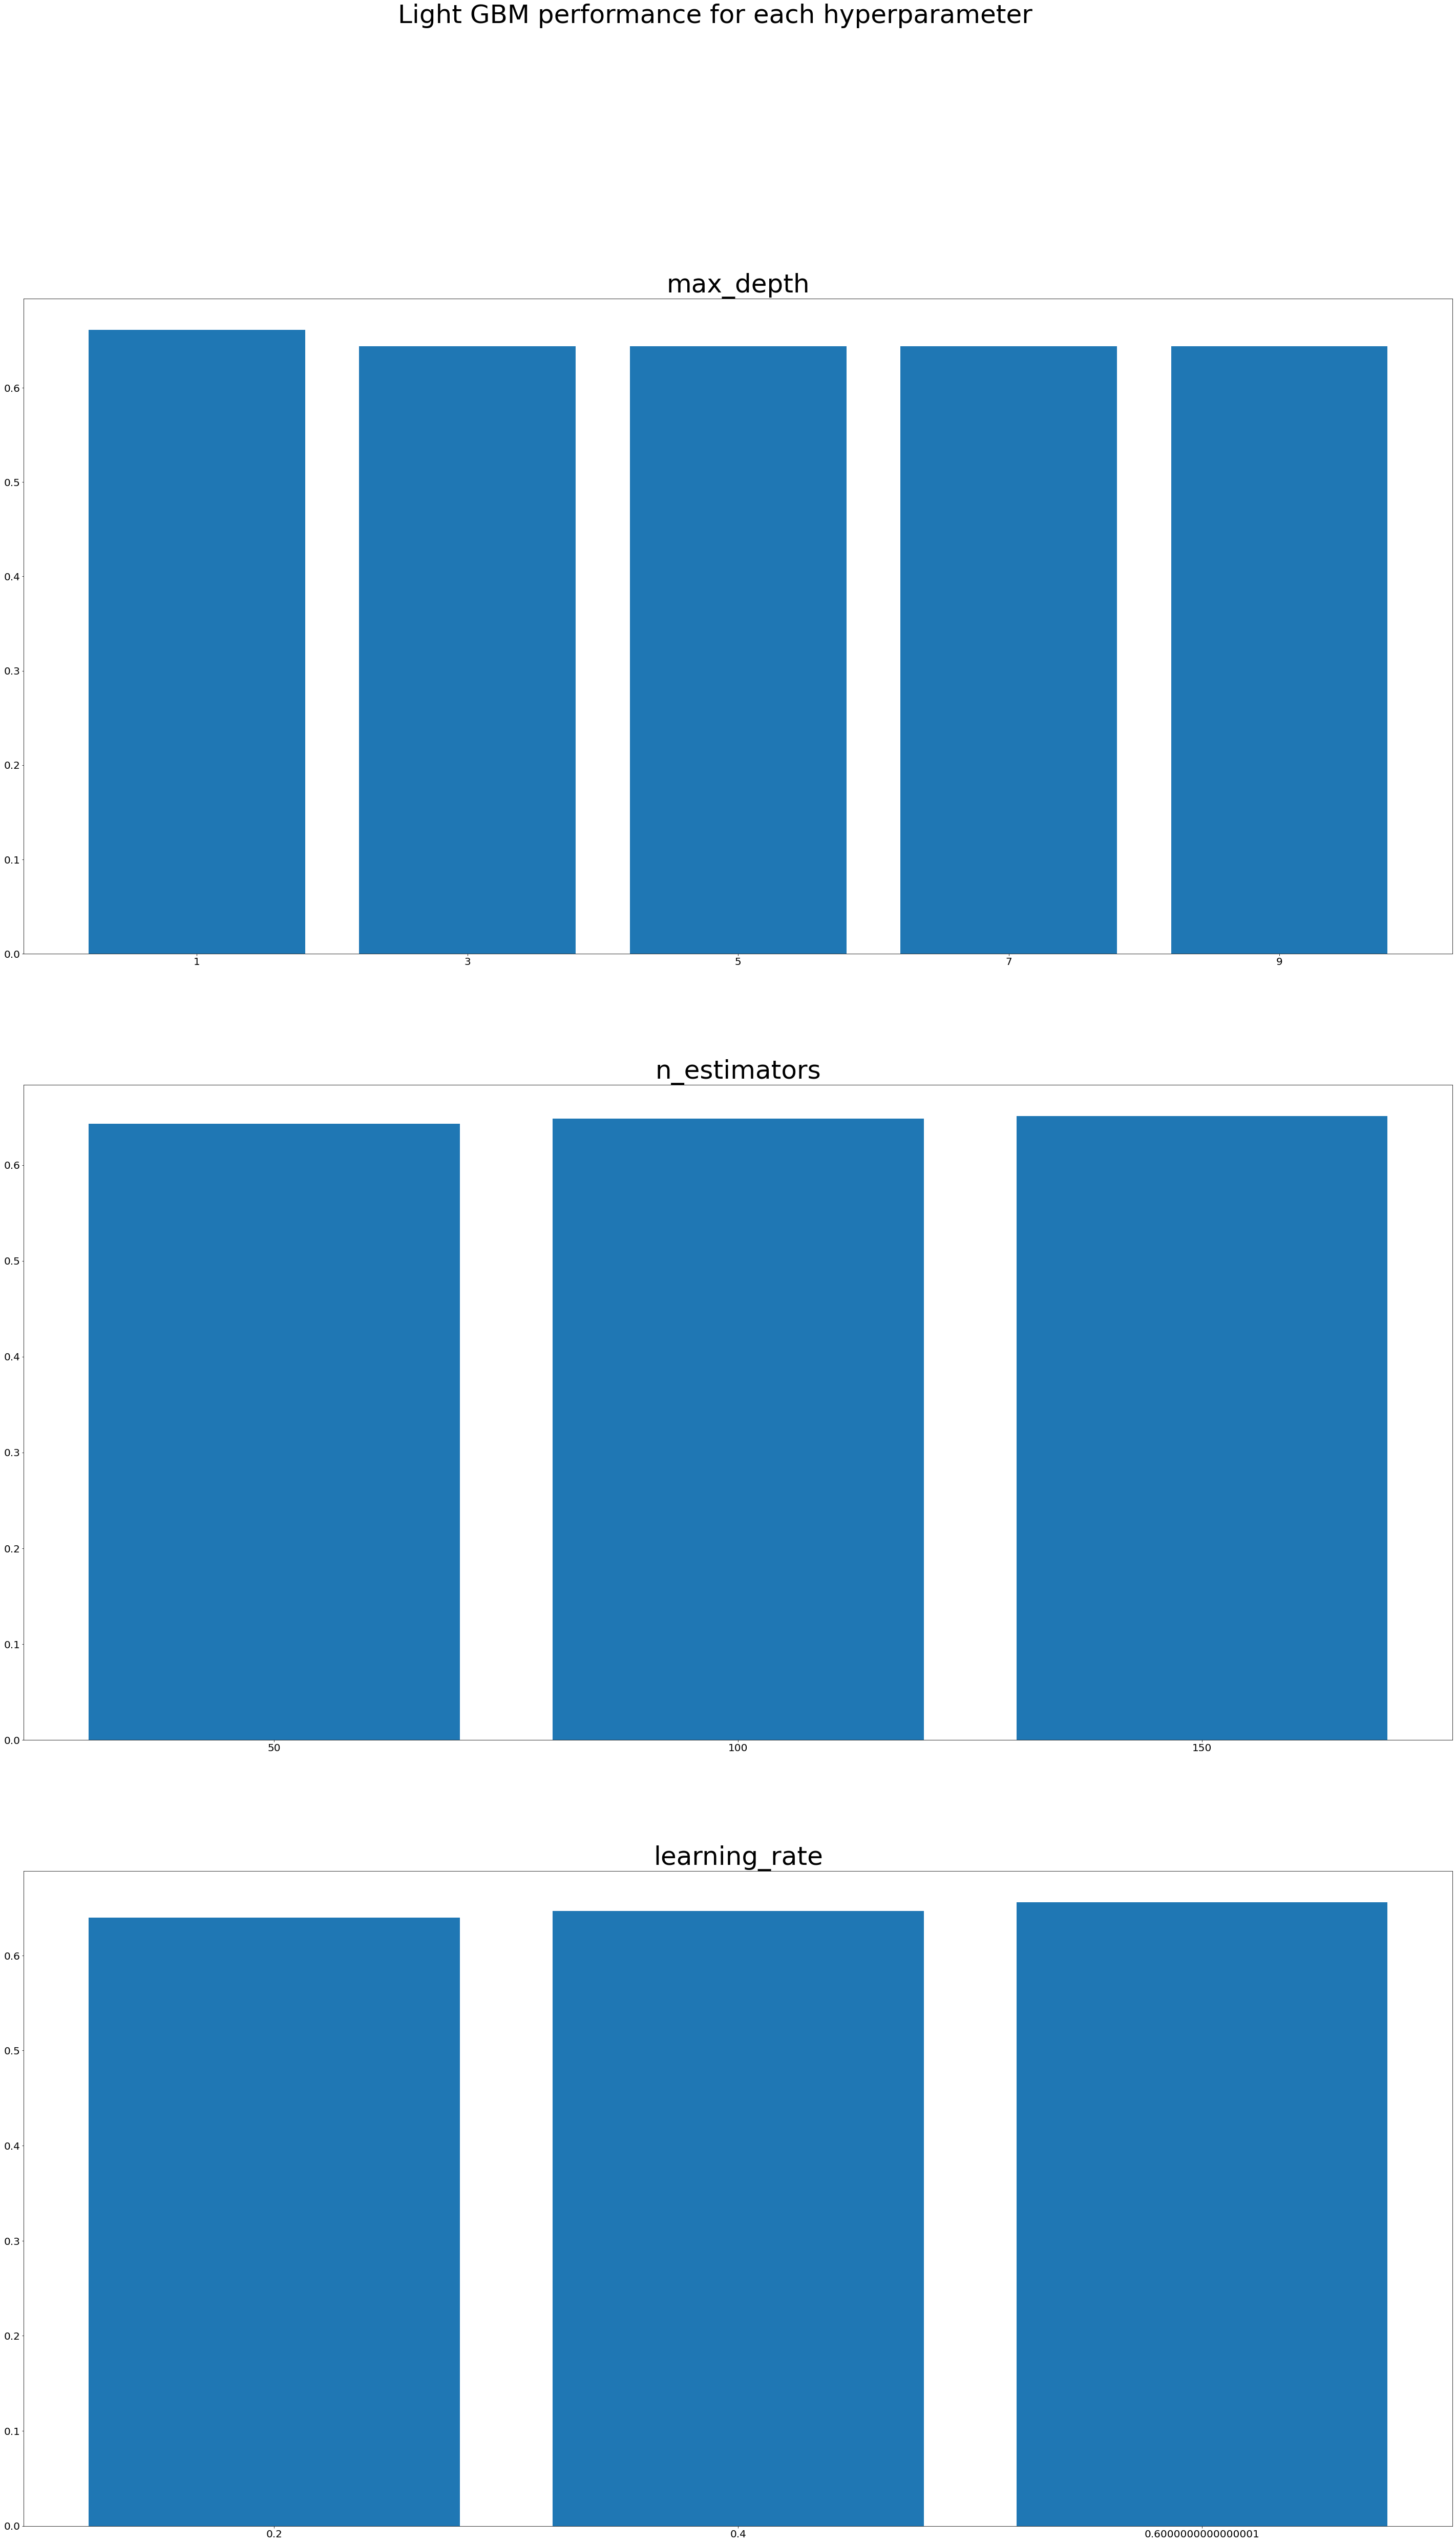

In [ ]:
model_name = 'Light GBM' # GBM , AdaBoost, Light GBM, Catboost

for_plot_values = output.loc[ output['model_name'] == model_name,:] # 예측 모델별 결과 확인을 위한 indexing

fig , axs = plt.subplots(nrows=model_params[model_name]['params'].keys().__len__(), ncols=1, figsize=(50,80)) # plot configure
fig.suptitle(f'{model_name} performance for each hyperparameter',fontsize=50) # 전체 Plot 제목

for ind , param_key in enumerate(model_params[model_name]['params'].keys()):
    
    param_for_plot = for_plot_values.groupby([f'param_{param_key}'])['mean_test_score'].mean() # 조절 하이퍼파라미터 이외에 대해서는 평균 성능 (개략적)
    
    axs[ind].bar(height = param_for_plot.values,x = [i for i in range(param_for_plot.values.shape[0])]) # bar plot 
    axs[ind].tick_params(axis='both',labelsize=20) # x,y 축 글씨 폰트 설정
    
    axs[ind].set_xticks([i for i in range(param_for_plot.values.shape[0])]) # x 축 ticks 설정
    axs[ind].set_xticklabels(param_for_plot.index.to_list()) # x 축 ticks 이름 설정

    axs[ind].set_title(f'{param_key}',fontsize=50) # 내부 plot 제목 

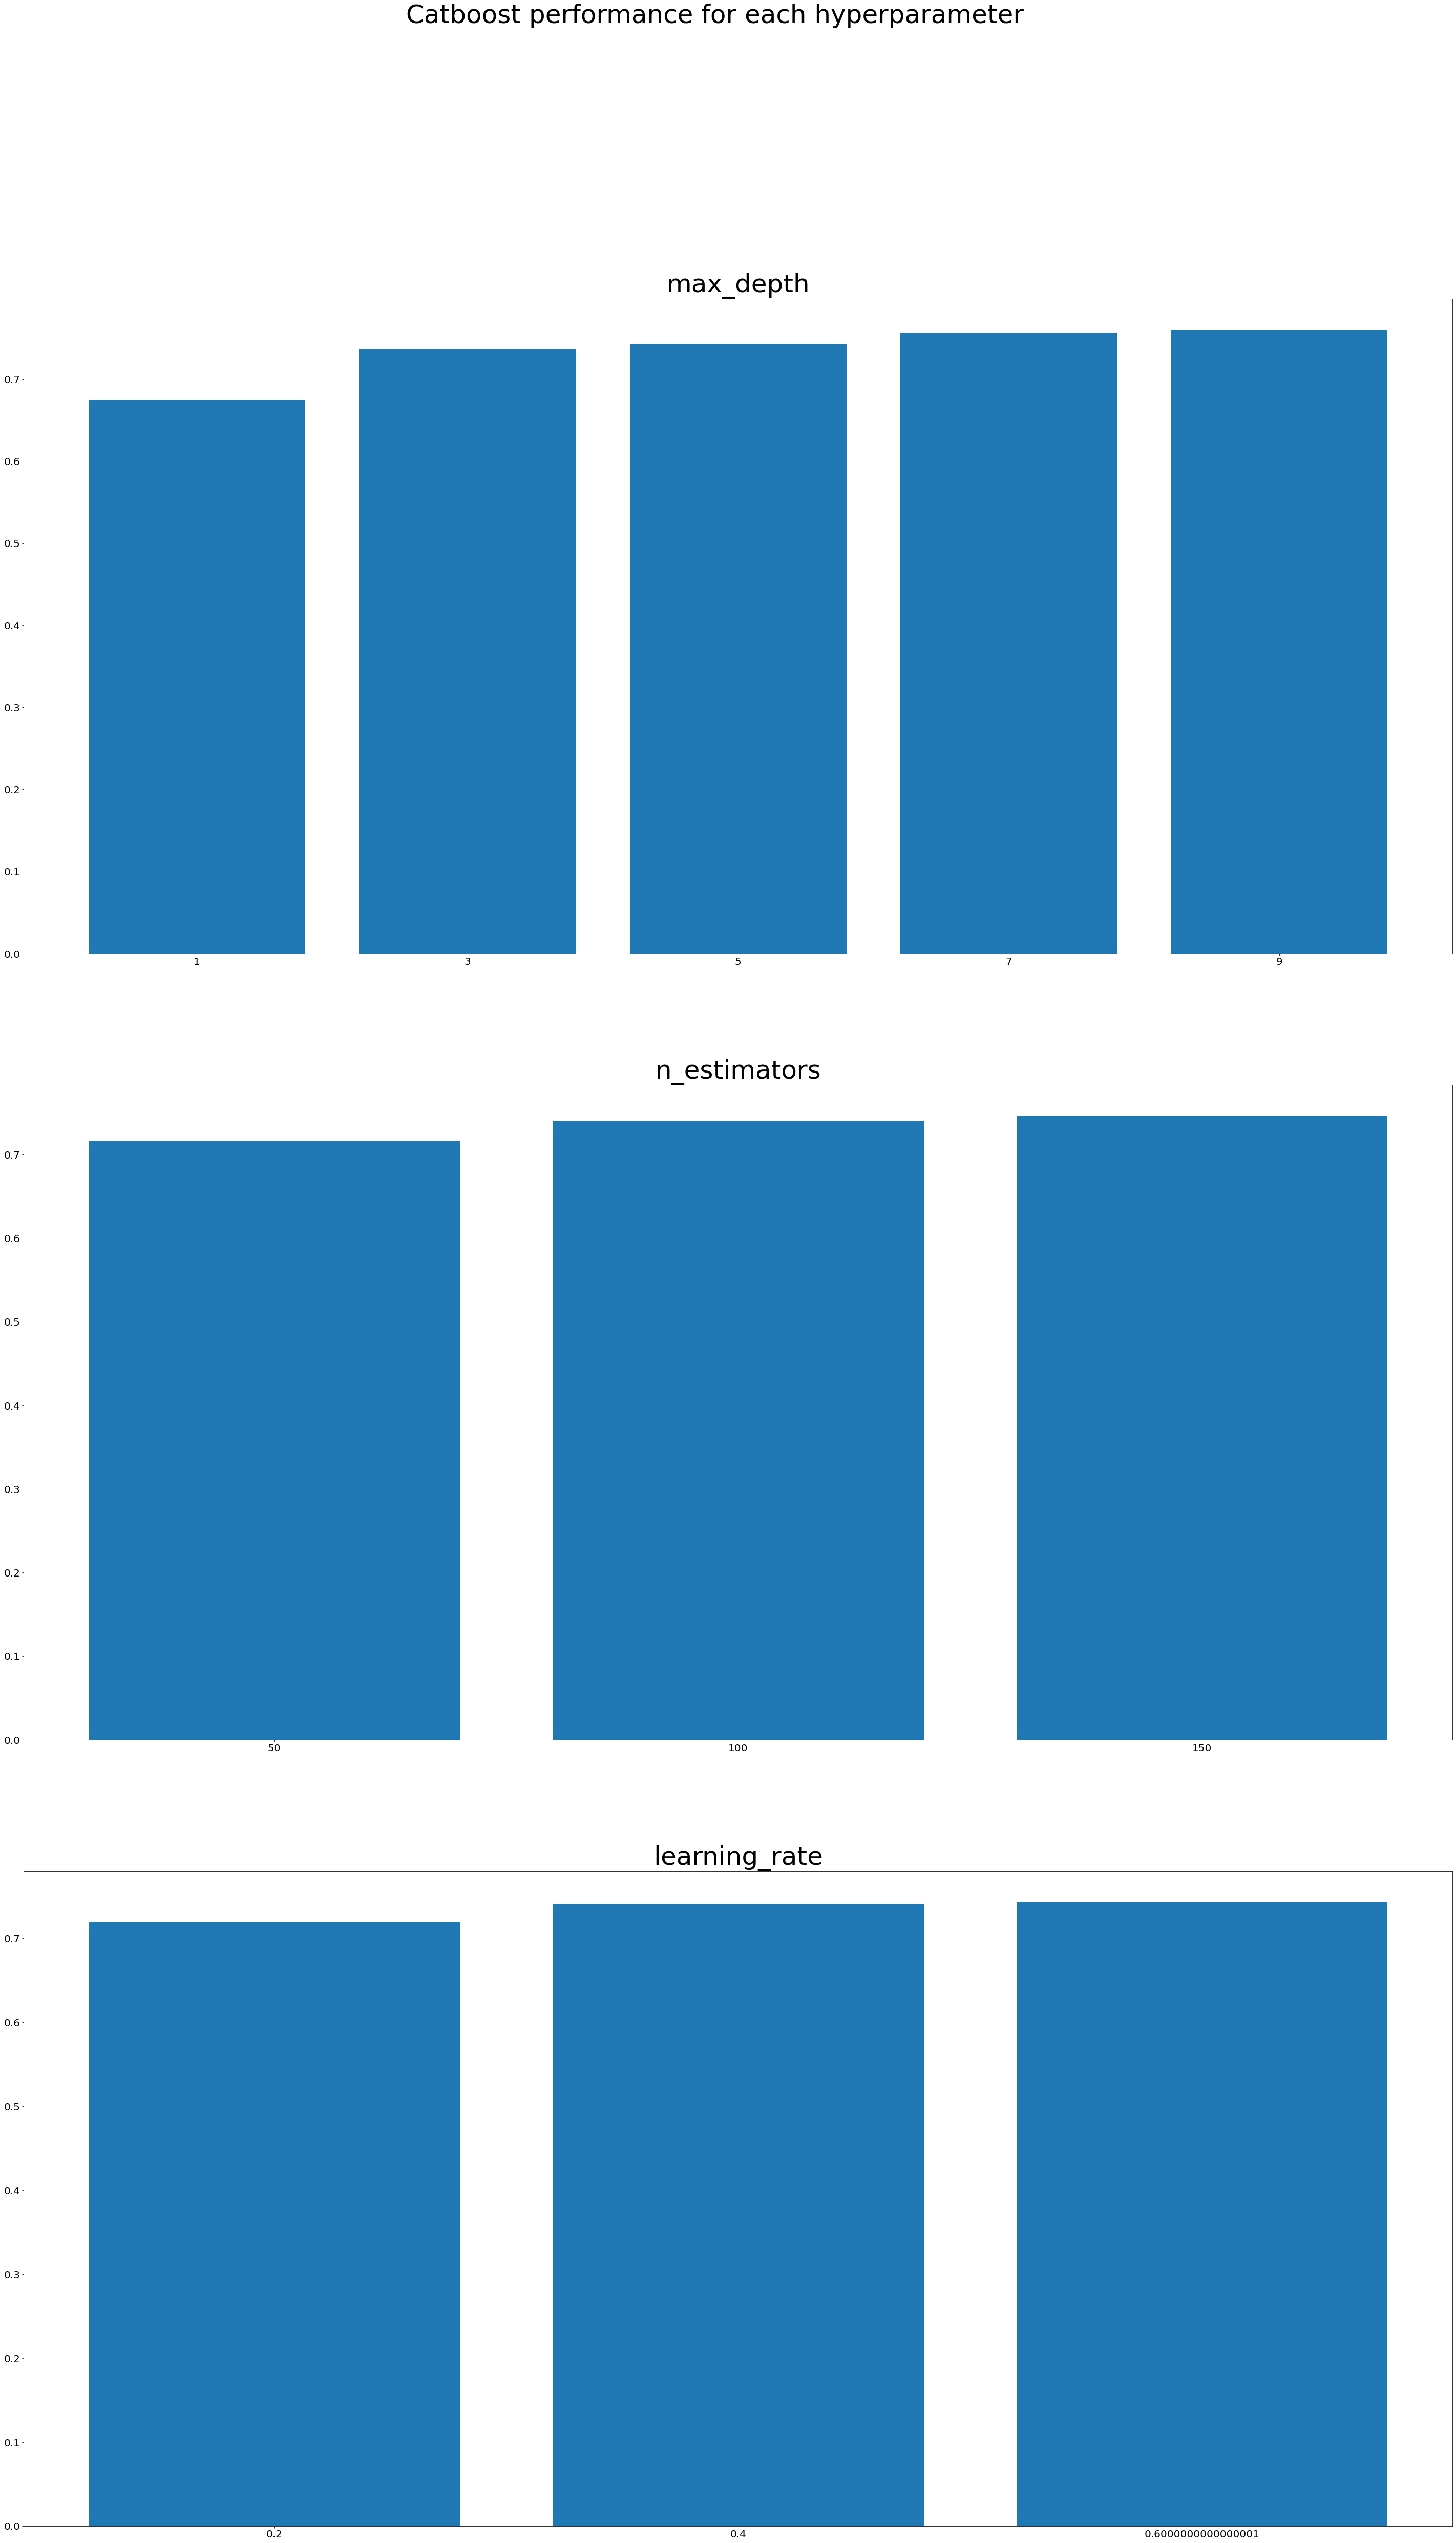

In [ ]:
model_name = 'Catboost' # GBM , AdaBoost, Light GBM, Catboost

for_plot_values = output.loc[ output['model_name'] == model_name,:] # 예측 모델별 결과 확인을 위한 indexing

fig , axs = plt.subplots(nrows=model_params[model_name]['params'].keys().__len__(), ncols=1, figsize=(50,80)) # plot configure
fig.suptitle(f'{model_name} performance for each hyperparameter',fontsize=50) # 전체 Plot 제목

for ind , param_key in enumerate(model_params[model_name]['params'].keys()):
    
    param_for_plot = for_plot_values.groupby([f'param_{param_key}'])['mean_test_score'].mean() # 조절 하이퍼파라미터 이외에 대해서는 평균 성능 (개략적)
    
    axs[ind].bar(height = param_for_plot.values,x = [i for i in range(param_for_plot.values.shape[0])]) # bar plot 
    axs[ind].tick_params(axis='both',labelsize=20) # x,y 축 글씨 폰트 설정
    
    axs[ind].set_xticks([i for i in range(param_for_plot.values.shape[0])]) # x 축 ticks 설정
    axs[ind].set_xticklabels(param_for_plot.index.to_list()) # x 축 ticks 이름 설정

    axs[ind].set_title(f'{param_key}',fontsize=50) # 내부 plot 제목 

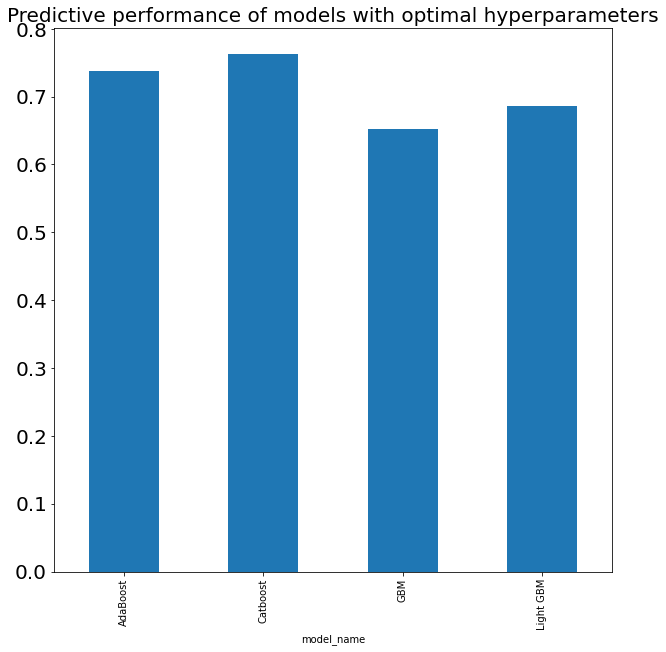

In [ ]:
## 최적의 하이퍼파라미터를 탑재한 예측 모델의 K-fold 예측 성능 시각화

plt.figure(figsize=(10,10))
output.groupby(['model_name'])['mean_test_score'].max().plot.bar()
plt.title('Predictive performance of models with optimal hyperparameters',fontsize=20)
plt.yticks(fontsize=20)
plt.show()

Catboost 모델은 특히 0.8의 정확도에 가깝게 예측한 것을 볼 수 있다.

## 6. Bagging 도입

1. Voting(보팅)
 
서로 다른 머신러닝 모델들의 예측을 통해서 최종 예측 값을 반환하는 것을 의미한다. 

Hard Voting : 
각 분류기의 예측 결과만을 참고하여 최종 예측 값을 산출해내는 것을 의미한다. 

Soft Voting :
각 분류기의 0과 1의 예측 확률을 평균을 내어 평균 값으로 최종 결과를 산출하는 방식을 의미한다.

설명한 것처럼 Soft Voting이 더 세부적인 정보를 사용하므로, 
일반적으로 Soft Voting이 더 좋은 성능을 보인다. 


2. Bagging(배깅)
 

Bagging 방식은 Voting 방식과는 다르게 같은 종류의 학습기를 이용한다. 
하지만, 그렇게 되면 동일한 학습과정을 거치고 동일한 예측 결과를 산출하지 않을까?
당연히 같은 데이터를 입력받는다면 그렇게 되겠지만, Bagging 방식은 입력하는 데이터에 차이를 준다.

여러 개의 데이터 세트를 중첩되게 분리하는 것을 부트스트래핑(Bootstrapping)이라고 하며, 여기에서 Bagging이라는 용어가 탄생하게 되었다. 
( bootstrap aggregating의 줄임말 )
부트스트랩은 통계학에서 여러개의 작은 데이터 세트를 임의로 만들어 개별 평균의 분포도를 측정하는 등의 목적을 위한 샘플링 방식을 지칭한다. 


Bagging 방식의 가장 유명한 기법은 랜덤 포레스트(Random Forest)이다. 
랜덤포레스트는 개별 분류기가 결정 트리이다.
 

Bagging의 단점 : 
- 하이퍼 파라미터가 너무 많다. : 
기본적으로 결정 트리의 하이퍼 파라미터도 많은데, 여기에 배깅, 부스팅, 학습, 정규화 등을 위한 파라미터로 인해서 너무 많은 하이퍼 파라미터를 가지고 있다.

- 수행 시간이 오래 걸린다. 

- 튜닝을 한 결과가 이전의 결과에 비해서 크게 성능에 향상이 없다. 

Bagging 
- Bootstrap Aggregation의 약자. 배깅은 샘플을 여러 번 뽑아(Bootstrap) 각 모델을 학습시켜 결과물을 집계(Aggregration)하는 방법. 


In [ ]:
# KNN bagging

model = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=13, p=1),
                          n_estimators = 10, max_samples = 0.8)
model.fit(X_train, y_train)
print('The accuracy for bagged KNN is:', model.score(X_test, y_test) )

The accuracy for bagged KNN is: 0.46875


In [ ]:
# Decision Tree Bagging

model =BaggingClassifier(base_estimator=  DecisionTreeClassifier(max_depth=11),
                         n_estimators = 10, max_samples = 0.8)
model.fit(X_train, y_train)
print('The accuracy for bagged decision tree is', model.score(X_test, y_test))

The accuracy for bagged decision tree is 0.625
